# Predict bank customers conversion probability

In [1]:
%matplotlib inline
import psycopg2
import pickle

from PIL import Image

# data processing
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Supervised Learning
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# Model Evaluation
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Explainability
import graphviz
import shap

c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Data

the dataset is available here: https://archive.ics.uci.edu/ml/datasets/bank+marketing

Find the best strategies to improve for the next marketing campaign. How can the financial institution have a greater effectiveness for future marketing campaigns? In order to answer this, we have to analyze the last marketing campaign the bank performed and identify the patterns that will help us find conclusions in order to develop future strategies.

## Attribute Information:

Input variables:
### bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
# load data from local csv 
df = pd.read_csv(
        filepath_or_buffer = '../data/bank-additional-full.csv',
        sep=';'
)

# drop a few columns which are typically not available in many scenarios or columns which leads to leakage b/c it cannot be known beforehand!
df.drop(
        labels=['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed'], 
        axis=1, 
        inplace=True)

# make feature denoting if there was a previous contact
df['previous_contact'] = (df['pdays'] != 999).apply(lambda x: 'no' if x==False else 'yes')

# insert random value if value equal 999 since the values is not defined
df['pdays'] = df['pdays'].apply(lambda x: np.nan if x==999 else x)

# encode target column
df['y'] = df['y'].apply(lambda x: 0 if x=='no' else 1)

df.head()

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y,previous_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,0,no


## Utility Functions

In [3]:
def get_data_from_my_postgre_db(password:str, table_name:str)->pd.DataFrame:
    """connects to marketing_analytics db and returns data from table_name as pandas dataframe .
    inputs: database password and table_name"""
    # Connect to the database
    conn = psycopg2.connect(
        database="marketing_analytics", 
        user="postgres", 
        password=password, 
        host="localhost", 
        port="5432")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a SQL query
    #cur.execute("SELECT * FROM bank_customers_churn_dataset")
    cur.execute("SELECT * FROM " + table_name) 
    # Get the column names from the cursor description
    columns = [desc[0] for desc in cur.description]
    # Fetch the results i.e. values
    results = cur.fetchall()
    # Create a dictionary mapping column names to values
    data = [dict(zip(columns, row)) for row in results]
    # Close the connection
    conn.close()
    # turn dictionary into dataframe
    return pd.DataFrame.from_dict(data)

def create_missing_values(df:pd.DataFrame, na_percentage=0.05)->pd.DataFrame:
    """impute missing values in na_percentage of rows in each column"""
    X = df.copy()
    # Create an array of 5 percent of the number of rows in the dataframe
    num_rows = X.shape[0]
    num_missing_values = int(num_rows * na_percentage)

    # Iterate through each row and set the values to np.nan
    for col in X.columns:
        # Get a random sample of rows from 0 to num_rows-1
        random_indices = random.sample(X.index.to_list(), num_missing_values)
        for row in random_indices:  
            X.loc[row, col] = np.nan
    return X

def create_outliers(df:pd.DataFrame, numeric_columns:list, na_percentage=0.05)->pd.DataFrame:
    """impute outliers in na_percentage of rows in each numeric column"""
    X = df.copy()
    # Create an array of 5 percent of the number of rows in the dataframe
    num_rows = X.shape[0]
    num_outliers = int(num_rows * na_percentage)

    # Iterate through each row and set the values to np.nan
    for col in X[numeric_columns]:
        # get mean value, standard deviation and minimum
        mean, sd, min = X[col].mean(), X[col].std(), X[col].min()
        # Generate random numbers from normal distribution
        rand_norm = np.random.normal(mean, sd, 1000000)
        # Generate outliers which are at least mean+/-3*std
        if min < 0:
            outliers = np.append(rand_norm[rand_norm < mean-3*sd], rand_norm[rand_norm > mean+3*sd])
        else:
            outliers = rand_norm[rand_norm > mean+3*sd]

        # Get a random sample of rows from 0 to num_rows-1
        random_indices = random.sample(X.index.to_list(), num_outliers)
        for row in random_indices:
            X.loc[row, col] = random.sample(outliers.tolist(), 1)[0]
    return X

def get_class_imbalance_correction_factor(data:pd.DataFrame, target:str):
    """calculate the class imbalance correction factor for the minority class for better fit performance"""
    value_counts = data[target].value_counts() / data.shape[0]
    return value_counts[0] / value_counts[1]

def calculate_engagement_rate(data:pd.DataFrame)->float:
    """get the marketing engagement rate in percent given data frame with column "converter" labeling whether canverted or not"""
    conversion_rate_pct = np.round((data.groupby(by='converter').count().iloc[:,0] / data.shape[0] * 100) [1],2)
    return conversion_rate_pct

def plot_threshold_recall_precision_curves(model, X, y):
    """plot threshold-recall-precision curves given trained model X and y"""
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    y_scores = model.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(y, y_scores)

    ax[0].plot(recall, precision)
    ax[0].set_title("Precision-Recall Curve")
    ax[0].set_xlabel('recall')
    ax[0].set_ylabel('precision')
    ax[0].set_xlim(-0.05, 1.05)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].grid()

    ax[1].plot(recall, np.insert(thresholds, 0, 0))
    ax[1].set_title("Threshold-Recall Curve")
    ax[1].set_xlabel('recall')
    ax[1].set_ylabel('threshold')
    ax[1].set_xlim(-0.05, 1.05)
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].grid()
    return fig

def plot_confusion_matrix(features:pd.DataFrame, labels:np.array, sklearn_model, threshold=0.5):
    """plot confusion matrix for trained model given labels and one-hotencoded features. Pick a decision threshold for positive class"""
    # make predictions
    preds = sklearn_model.predict_proba(features)[:,1]
    preds = np.where(preds>threshold, 1, 0)
    # calc confusion matrix
    cm = confusion_matrix(labels, preds, labels=sklearn_model.classes_)
    # create matrix display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,                            
        display_labels=sklearn_model.classes_)
    disp.plot()
    return disp

In [4]:
#f = open("../private.txt", "r")
#pw = f.read()

In [5]:
## get data from postres db
#table_name = "bank_customers_churn_dataset"
#df = get_data_from_my_postgre_db(pw, table_name)
#
## set customer id as index
#df.set_index('customer_id', inplace=True)
#
## change churn column type to bool
#df['churn'] = df['churn'].astype('int').astype('bool')
#
## change data types to numeric
#df['tenure'] = df['tenure'].apply(lambda x: int(x))
#df['products_number'] = df['products_number'].apply(lambda x: int(x))
#df['credit_card'] = df['credit_card'].apply(lambda x: int(x))
#df['active_member'] = df['active_member'].apply(lambda x: int(x))
#
## change type of categorical columns "credit_card" and "active_member"
#df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
#df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')

In [6]:
df.dtypes

age                   int64
job                  object
marital              object
education            object
default              object
housing              object
loan                 object
contact              object
month                object
day_of_week          object
campaign              int64
pdays               float64
previous              int64
poutcome             object
y                     int64
previous_contact     object
dtype: object

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y,previous_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,0,no


## Split Features and Target

In [8]:
# divide features and target
y = df['y'].values
X = df.drop('y', axis=1)

## Check Column Types

In [9]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = X.select_dtypes(include=numerics).columns.to_list()
categorical_columns = X.select_dtypes(exclude=numerics).columns.to_list()

print('numeric columns: {}'.format(numeric_columns))
print('categorical columns: {}'.format(categorical_columns))

numeric columns: ['age', 'campaign', 'pdays', 'previous']
categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'previous_contact']


In [10]:
# check unique values for categorical values
for col in categorical_columns:
    print('unique values for {}: \n{}'.format(col, df[col].unique()))


unique values for job: 
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
unique values for marital: 
['married' 'single' 'divorced' 'unknown']
unique values for education: 
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
unique values for default: 
['no' 'unknown' 'yes']
unique values for housing: 
['no' 'yes' 'unknown']
unique values for loan: 
['no' 'yes' 'unknown']
unique values for contact: 
['telephone' 'cellular']
unique values for month: 
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
unique values for day_of_week: 
['mon' 'tue' 'wed' 'thu' 'fri']
unique values for poutcome: 
['nonexistent' 'failure' 'success']
unique values for previous_contact: 
['no' 'yes']


# Train-Test Split the Data

In [11]:
# way too much data for training; let´s split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.90, 
    stratify=y,
    random_state=123)

In [12]:
X_train.shape

(4118, 15)

In [13]:
X_test.shape

(37070, 15)

In [14]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,previous_contact
13583,25,technician,married,professional.course,no,no,no,cellular,jul,thu,3,NaN,0,nonexistent,no
5572,42,housemaid,married,basic.4y,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,no
4906,44,technician,married,high.school,unknown,yes,no,telephone,may,wed,2,NaN,0,nonexistent,no
24720,37,entrepreneur,married,university.degree,unknown,yes,no,telephone,nov,mon,1,NaN,1,failure,no
1298,31,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,1,NaN,0,nonexistent,no


## Simulate Additional Missing Values and Outliers to Ensure the Methods for Recovery Work

In [15]:
# create some more missing data in 5% of all rows to ensure enough missing data to test the missing data imputation methods
X_train = create_missing_values(X_train, na_percentage=0.05)
X_test = create_missing_values(X_test, na_percentage=0.05)

In [16]:
# create additional outliers in 5% of the rows to test out outlier removal method
X_train = create_outliers(X_train, numeric_columns, 0.05)
X_test = create_outliers(X_test, numeric_columns, 0.05)

# Data Analysis Preparation

In [17]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,previous_contact
13583,25.0,technician,married,professional.course,no,no,no,cellular,NaN,thu,3.000000,NaN,0.00000,nonexistent,no
5572,42.0,housemaid,NaN,basic.4y,no,yes,no,telephone,NaN,mon,1.000000,NaN,0.00000,nonexistent,no
4906,44.0,technician,married,high.school,unknown,yes,no,telephone,may,wed,2.000000,NaN,0.00000,nonexistent,no
24720,37.0,entrepreneur,married,university.degree,unknown,yes,no,telephone,nov,mon,1.000000,NaN,1.00000,failure,no
1298,31.0,blue-collar,married,basic.9y,NaN,no,no,telephone,may,thu,1.000000,NaN,0.00000,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10745,34.0,entrepreneur,single,professional.course,no,no,no,telephone,jun,tue,11.978971,NaN,0.00000,nonexistent,no
16796,41.0,entrepreneur,single,high.school,no,NaN,no,cellular,jul,thu,1.000000,NaN,1.98791,nonexistent,no
35500,46.0,NaN,married,basic.9y,no,yes,no,cellular,may,mon,1.000000,NaN,0.00000,nonexistent,no
21528,50.0,blue-collar,NaN,basic.4y,no,yes,no,cellular,aug,tue,1.000000,NaN,0.00000,nonexistent,no


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4118 entries, 13583 to 24475
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               3924 non-null   float64
 1   job               3913 non-null   object 
 2   marital           3913 non-null   object 
 3   education         3913 non-null   object 
 4   default           3913 non-null   object 
 5   housing           3913 non-null   object 
 6   loan              3913 non-null   object 
 7   contact           3913 non-null   object 
 8   month             3913 non-null   object 
 9   day_of_week       3913 non-null   object 
 10  campaign          3923 non-null   float64
 11  pdays             337 non-null    float64
 12  previous          3926 non-null   float64
 13  poutcome          3913 non-null   object 
 14  previous_contact  3913 non-null   object 
dtypes: float64(4), object(11)
memory usage: 643.8+ KB


In [19]:
X_train.isna().sum()

age                  194
job                  205
marital              205
education            205
default              205
housing              205
loan                 205
contact              205
month                205
day_of_week          205
campaign             195
pdays               3781
previous             192
poutcome             205
previous_contact     205
dtype: int64

## Impute Missing Values

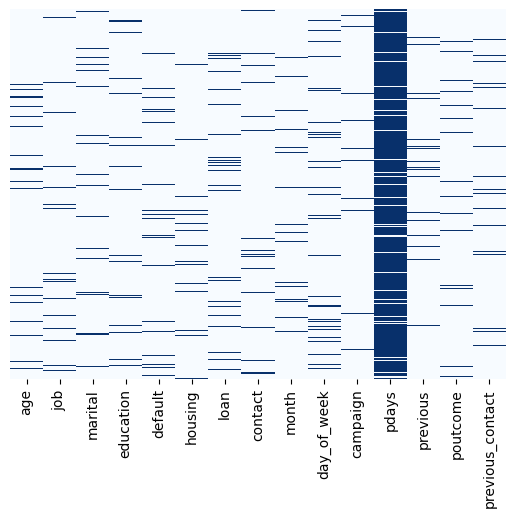

In [20]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [21]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)

# reformat to integer
X_train_numeric['previous'] = X_train_numeric['previous'].apply(lambda x: np.round(x,0)).astype('int')
X_train_numeric['campaign'] = X_train_numeric['campaign'].apply(lambda x: np.round(x,0)).astype('int')

X_train_numeric.head()

,age,campaign,pdays,previous
13583,25.0,3,16.148069,0
5572,42.0,1,16.148069,0
4906,44.0,2,16.148069,0
24720,37.0,1,16.148069,1
1298,31.0,1,16.148069,0


In [22]:
# impute missing numeric values in test dataset
X_test_numeric = numeric_imputer.transform(X_test.select_dtypes(include=numerics))
X_test_numeric = pd.DataFrame(X_test_numeric, columns=numeric_columns, index=X_test.index)

# reformat to integer
X_test_numeric['previous'] = X_test_numeric['previous'].apply(lambda x: np.round(x,0)).astype('int')
X_test_numeric['campaign'] = X_test_numeric['campaign'].apply(lambda x: np.round(x,0)).astype('int')

X_test_numeric.head()

,age,campaign,pdays,previous
9909,55.0,1,16.148069,0
8714,38.0,4,16.148069,0
11249,39.0,2,16.148069,0
26948,31.0,3,16.148069,0
11755,53.0,3,16.148069,0


In [23]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
13583,technician,married,professional.course,no,no,no,cellular,may,thu,nonexistent,no
5572,housemaid,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no
4906,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no
24720,entrepreneur,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no
1298,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no


In [24]:
# Impute missing categorical values in test dataset
X_test_categorical = categorical_imputer.transform(X_test.select_dtypes(exclude=numerics))
X_test_categorical = pd.DataFrame(X_test_categorical, columns=categorical_columns, index=X_test.index)
X_test_categorical.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
9909,technician,married,high.school,unknown,no,no,telephone,jun,wed,nonexistent,no
8714,technician,married,university.degree,unknown,no,no,telephone,jun,wed,nonexistent,no
11249,admin.,married,university.degree,no,no,no,telephone,jun,thu,nonexistent,no
26948,blue-collar,married,basic.9y,no,no,no,cellular,nov,thu,nonexistent,no
11755,technician,married,university.degree,no,yes,no,telephone,jun,fri,nonexistent,no


In [25]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
    pickle.dump(categorical_imputer, filename)

In [26]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
13583,25.0,3,16.148069,0,technician,married,professional.course,no,no,no,cellular,may,thu,nonexistent,no
5572,42.0,1,16.148069,0,housemaid,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no
4906,44.0,2,16.148069,0,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no
24720,37.0,1,16.148069,1,entrepreneur,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no
1298,31.0,1,16.148069,0,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no


In [27]:
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)
X_test.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
9909,55.0,1,16.148069,0,technician,married,high.school,unknown,no,no,telephone,jun,wed,nonexistent,no
8714,38.0,4,16.148069,0,technician,married,university.degree,unknown,no,no,telephone,jun,wed,nonexistent,no
11249,39.0,2,16.148069,0,admin.,married,university.degree,no,no,no,telephone,jun,thu,nonexistent,no
26948,31.0,3,16.148069,0,blue-collar,married,basic.9y,no,no,no,cellular,nov,thu,nonexistent,no
11755,53.0,3,16.148069,0,technician,married,university.degree,no,yes,no,telephone,jun,fri,nonexistent,no


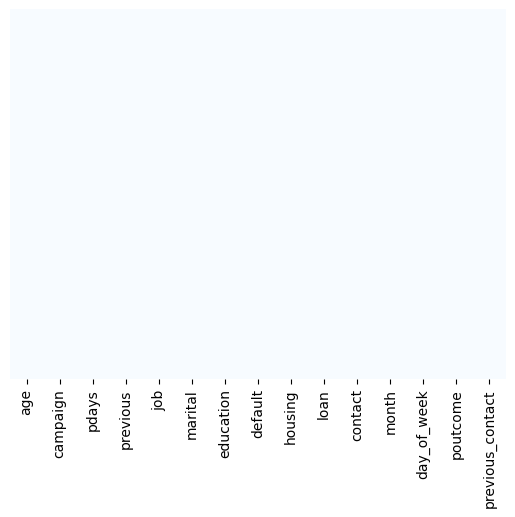

In [28]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_test.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Prepare Categorical Features

In [29]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category job: 
admin.           1229
blue-collar       874
technician        616
services          401
management        259
self-employed     143
entrepreneur      142
retired           134
unemployed        118
housemaid          97
student            84
unknown            21
Name: job, dtype: int64
Value counts in category marital: 
married     2587
single      1089
divorced     434
unknown        8
Name: marital, dtype: int64
Value counts in category education: 
university.degree      1376
high.school             943
basic.9y                588
professional.course     469
basic.4y                377
basic.6y                204
unknown                 160
illiterate                1
Name: education, dtype: int64
Value counts in category default: 
no         3329
unknown     789
Name: default, dtype: int64
Value counts in category housing: 
yes        2227
no         1793
unknown      98
Name: housing, dtype: int64
Value counts in category loan: 
no         3439
yes  

## Encode Rare Labels

In [30]:
# encode rare labels in train data
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=5)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

The number of unique categories for variable marital is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable default is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable housing is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable loan is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable contact is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable day_of_week is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable poutcome is less than that indicated in n_categories. Thus, all categori

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
13583,technician,married,professional.course,no,no,no,cellular,may,thu,nonexistent,no
5572,Rare,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no
4906,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no
24720,Rare,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no
1298,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no


In [31]:
# encode rare labels in test data
X_test[categorical_columns] = rare_encoder.transform(X_test[categorical_columns])
X_test[categorical_columns].head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
9909,technician,married,high.school,unknown,no,no,telephone,jun,wed,nonexistent,no
8714,technician,married,university.degree,unknown,no,no,telephone,jun,wed,nonexistent,no
11249,admin.,married,university.degree,no,no,no,telephone,jun,thu,nonexistent,no
26948,blue-collar,married,basic.9y,no,no,no,cellular,nov,thu,nonexistent,no
11755,technician,married,university.degree,no,yes,no,telephone,jun,fri,nonexistent,no


In [32]:
# Save rare label encoder
with open('../artifacts/rare_encoder.pickle', 'wb') as filename:
    pickle.dump(rare_encoder, filename)

## Prepare Numerical Features

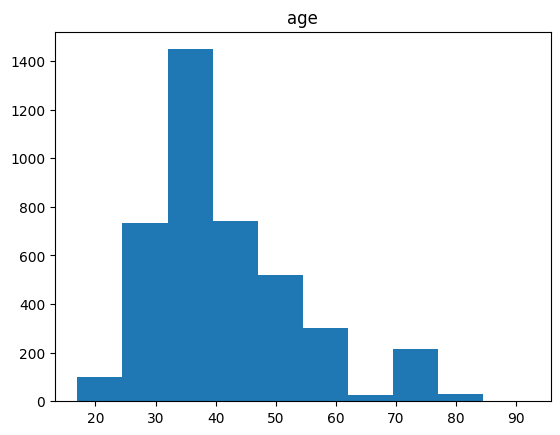

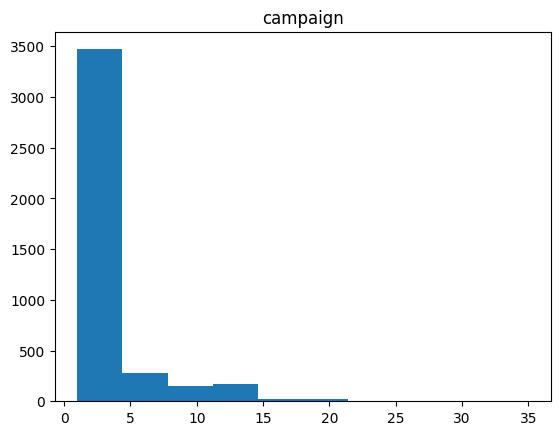

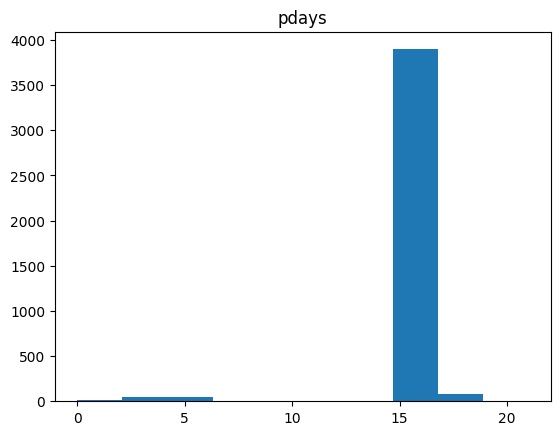

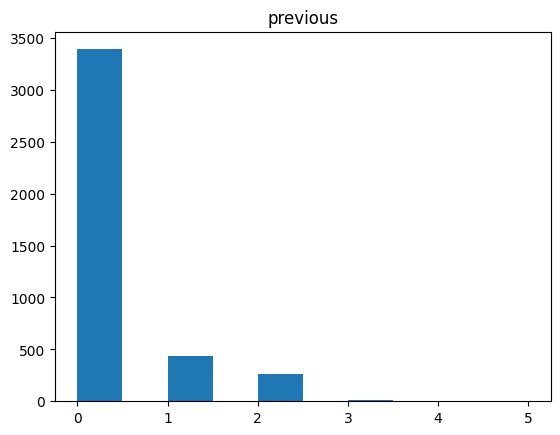

In [33]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [34]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [35]:
# fit the capper on train data
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
13583,25.0,3.0,16.148069,0.0,technician,married,professional.course,no,no,no,cellular,may,thu,nonexistent,no
5572,42.0,1.0,16.148069,0.0,Rare,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no
4906,44.0,2.0,16.148069,0.0,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no
24720,37.0,1.0,16.148069,1.0,Rare,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no
1298,31.0,1.0,16.148069,0.0,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no


In [36]:
# fit the capper on test data
X_test[numeric_columns] = capper.transform(X_test[numeric_columns])
X_test.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
9909,55.0,1.0,16.148069,0.0,technician,married,high.school,unknown,no,no,telephone,jun,wed,nonexistent,no
8714,38.0,4.0,16.148069,0.0,technician,married,university.degree,unknown,no,no,telephone,jun,wed,nonexistent,no
11249,39.0,2.0,16.148069,0.0,admin.,married,university.degree,no,no,no,telephone,jun,thu,nonexistent,no
26948,31.0,3.0,16.148069,0.0,blue-collar,married,basic.9y,no,no,no,cellular,nov,thu,nonexistent,no
11755,53.0,3.0,16.148069,0.0,technician,married,university.degree,no,yes,no,telephone,jun,fri,nonexistent,no


In [37]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

# Data Visualization

### Engagement Rate

In [38]:
data = pd.concat([X_train, pd.DataFrame(y_train, columns=['converter'], index=X_train.index)], axis=1)
data.head()

,age,campaign,pdays,previous,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact,converter
13583,25.0,3.0,16.148069,0.0,technician,married,professional.course,no,no,no,cellular,may,thu,nonexistent,no,0
5572,42.0,1.0,16.148069,0.0,Rare,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no,0
4906,44.0,2.0,16.148069,0.0,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no,0
24720,37.0,1.0,16.148069,1.0,Rare,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no,0
1298,31.0,1.0,16.148069,0.0,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no,0


In [39]:
print('Conversion rate: {} %'.format(calculate_engagement_rate(data))) 

Conversion rate: 11.27 %


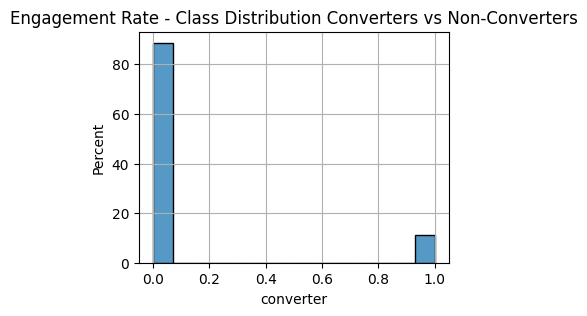

In [40]:
### Visualize Class Distribution

# plot class distribution for converters vs non-converters
fig, ax = plt.subplots(1,1,figsize=(4,3))
sns.histplot(
        data = data,
        x = 'converter',
        stat='percent',
        ax=ax
)
ax.grid()
ax.set_title('Engagement Rate - Class Distribution Converters vs Non-Converters')


# save figure
fig.savefig(
        fname='../images/engagement_rate.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
)

#plt.show()

## Visualize Numerical Features

In [41]:
# create numeric data frame
data = pd.concat([X_train[numeric_columns], pd.DataFrame(y_train, index=X_train.index, columns=['converter'])], axis=1)
data.head()

,age,campaign,pdays,previous,converter
13583,25.0,3.0,16.148069,0.0,0
5572,42.0,1.0,16.148069,0.0,0
4906,44.0,2.0,16.148069,0.0,0
24720,37.0,1.0,16.148069,1.0,0
1298,31.0,1.0,16.148069,0.0,0


In [42]:
data.groupby('converter').agg('median')

,age,campaign,pdays,previous
converter,,,,
0,39.0,2.0,16.148069,0.0
1,38.0,2.0,16.148069,0.0


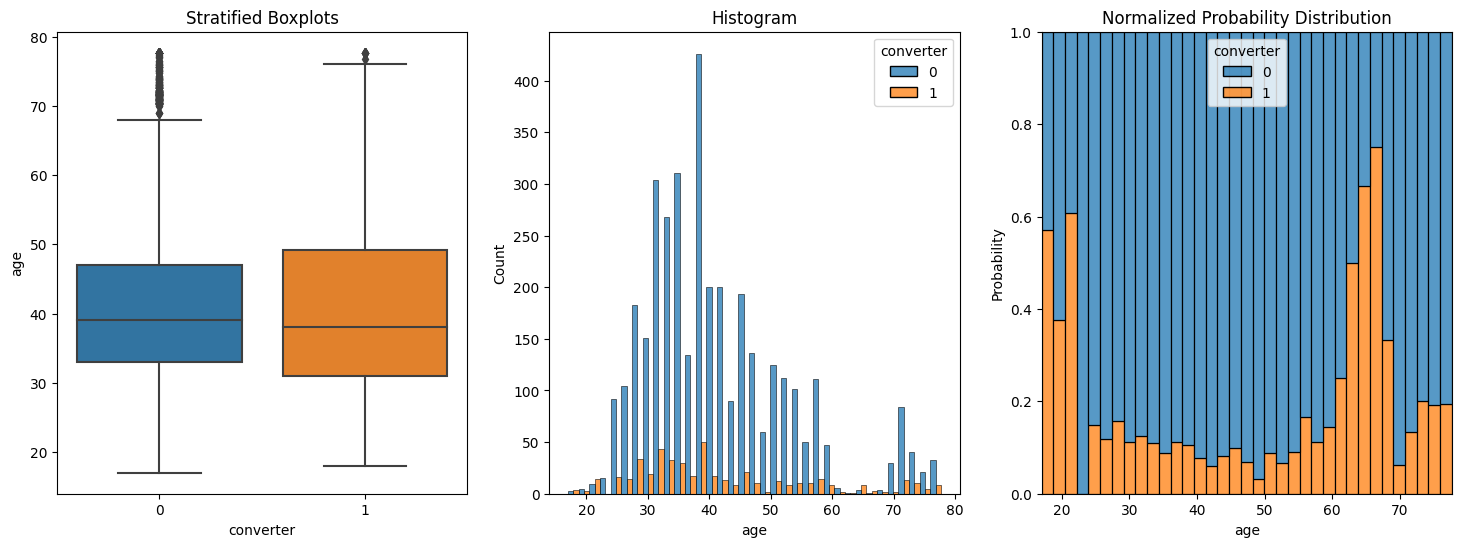

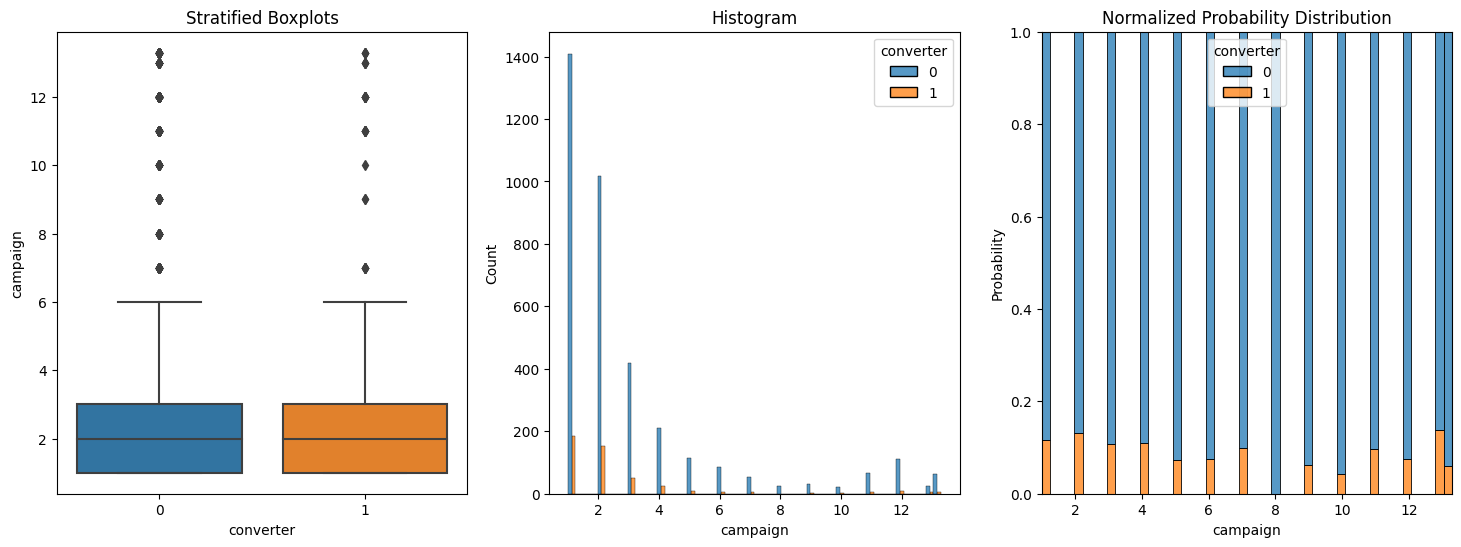

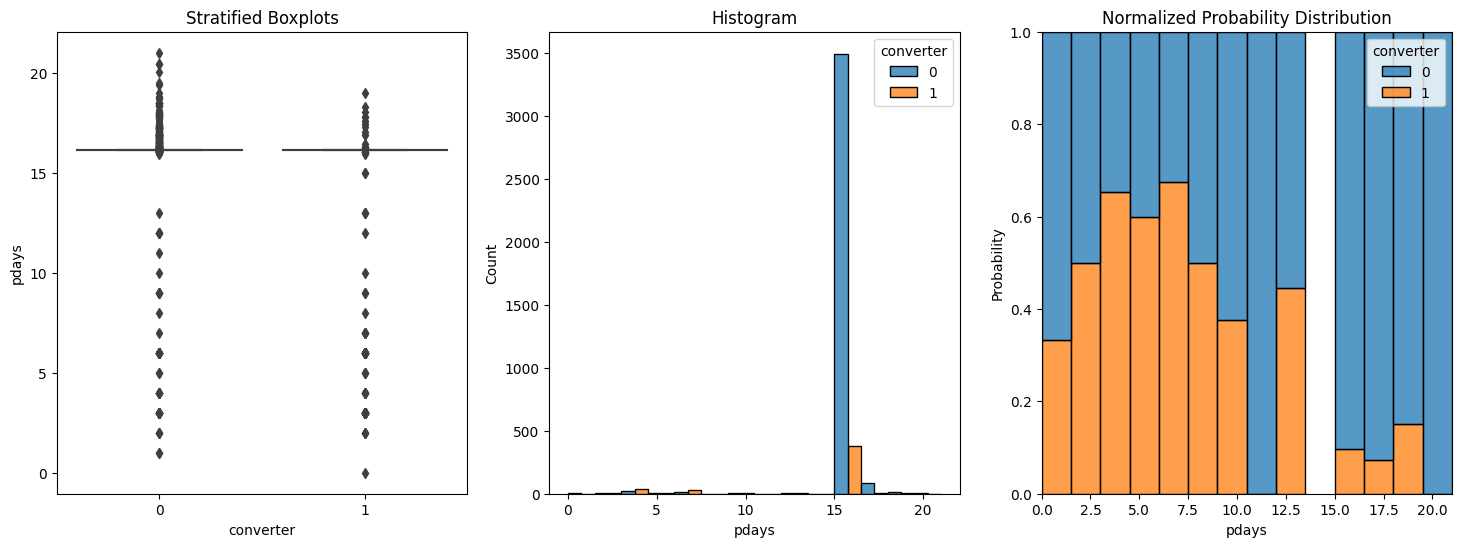

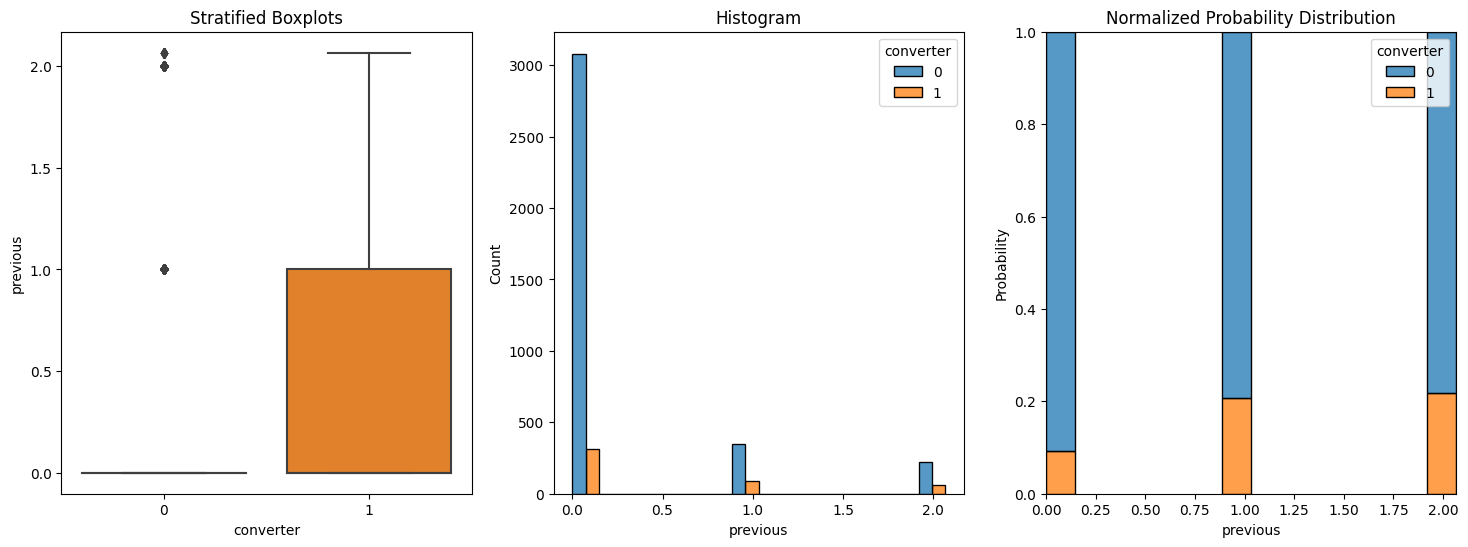

In [43]:
# plot box-plots and histograms
for feat in numeric_columns:

    fig, ax = plt.subplots(1, 3, figsize=(18,6))

    sns.boxplot(
        data = data,
        y = feat,
        x = 'converter',
        ax=ax[0]
    )
    ax[0].set_title('Stratified Boxplots')

    sns.histplot(
        data = data,
        x = feat,
        hue = 'converter',
        stat='count',
        multiple='dodge',
        ax = ax[1]
    )
    ax[1].set_title('Histogram')

    sns.histplot(
        data = data,
        x = feat,
        hue = 'converter',
        stat='probability',
        multiple='fill',
        ax = ax[2]
    )
    ax[2].set_title('Normalized Probability Distribution')

    # save figure
    fig.savefig(
        fname='../images/'+feat+'_dist.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight')

    #plt.show()

## Visualize Categorical Features

In [44]:
# create categorical data frame
data = pd.concat([X_train[categorical_columns], pd.DataFrame(y_train, index=X_train.index, columns=['converter'])], axis=1)
data.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact,converter
13583,technician,married,professional.course,no,no,no,cellular,may,thu,nonexistent,no,0
5572,Rare,married,basic.4y,no,yes,no,telephone,may,mon,nonexistent,no,0
4906,technician,married,high.school,unknown,yes,no,telephone,may,wed,nonexistent,no,0
24720,Rare,married,university.degree,unknown,yes,no,telephone,nov,mon,failure,no,0
1298,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,nonexistent,no,0


In [45]:
# show most frequent categories for converters vs non-converters
data.groupby('converter').agg(pd.Series.mode)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,previous_contact
converter,,,,,,,,,,,
0,admin.,married,university.degree,no,yes,no,cellular,may,mon,nonexistent,no
1,admin.,married,university.degree,no,yes,no,cellular,Rare,mon,nonexistent,no


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFor

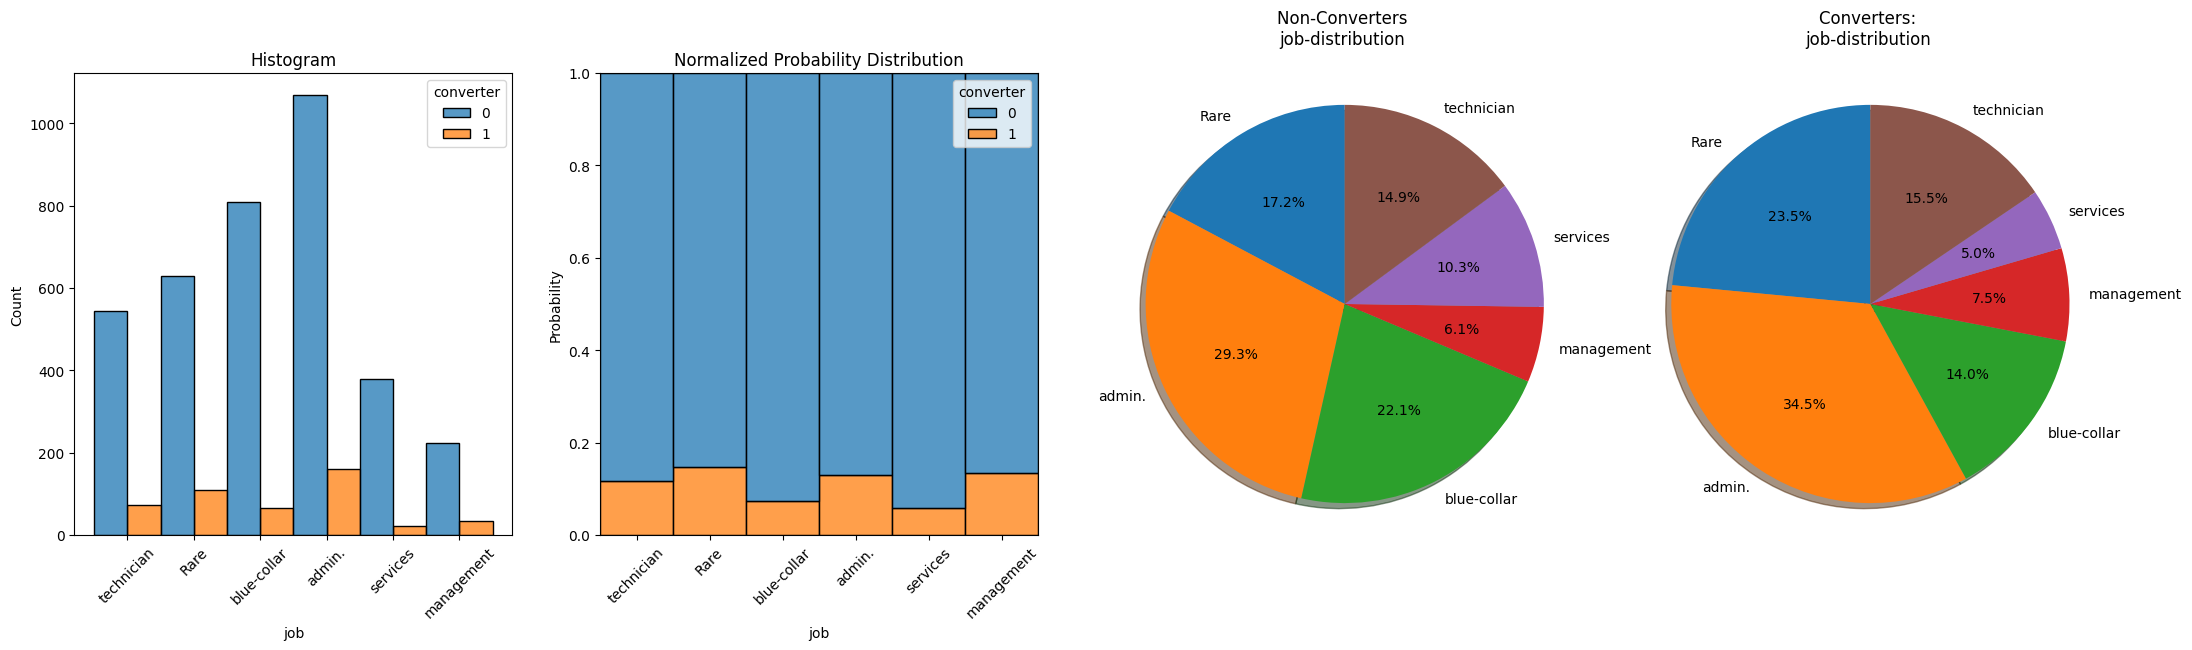

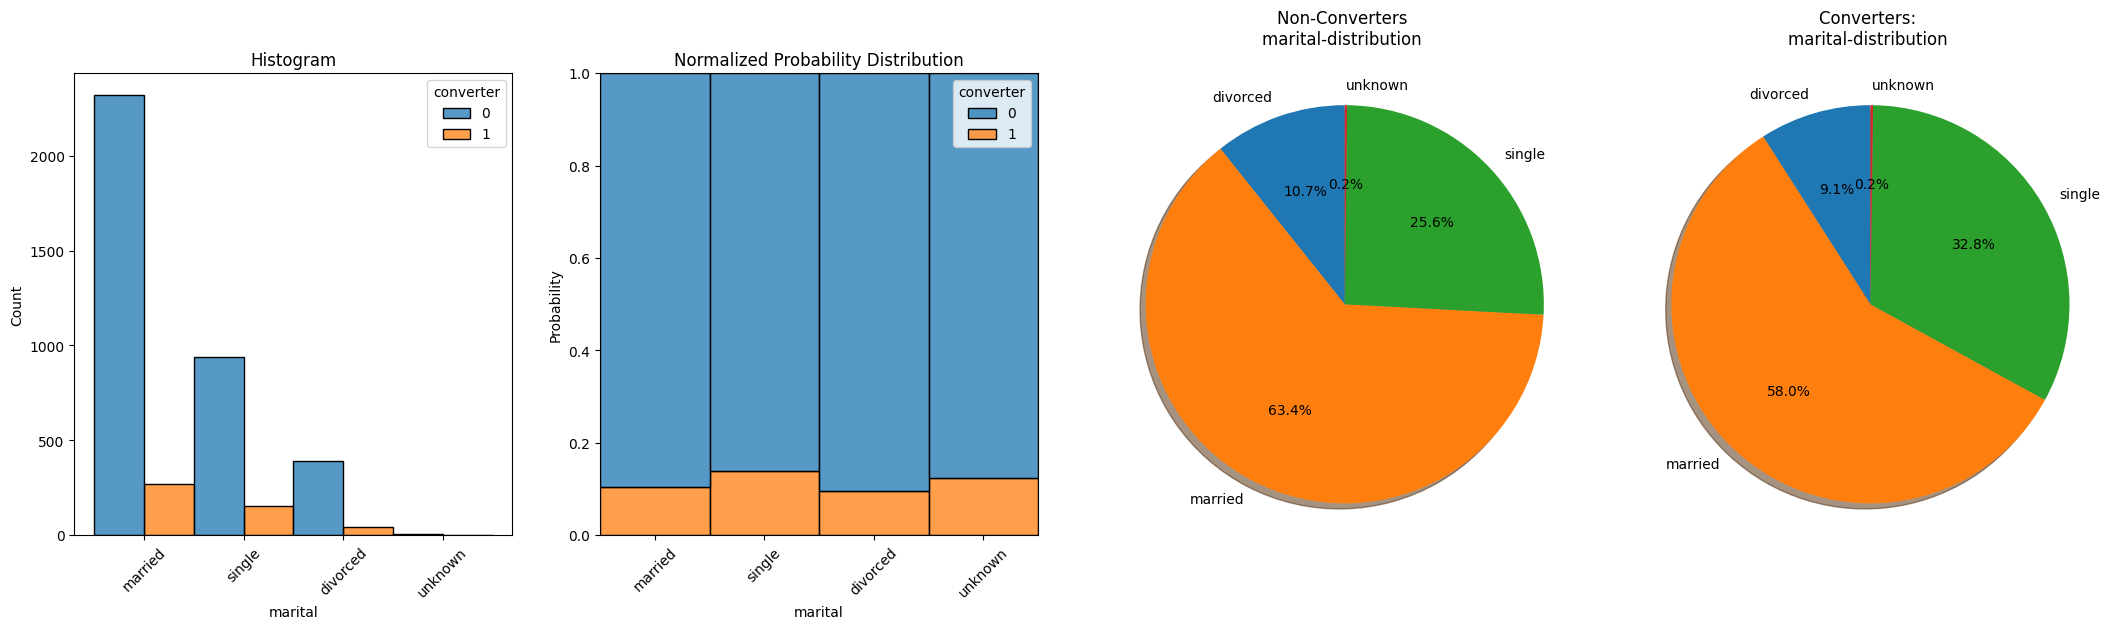

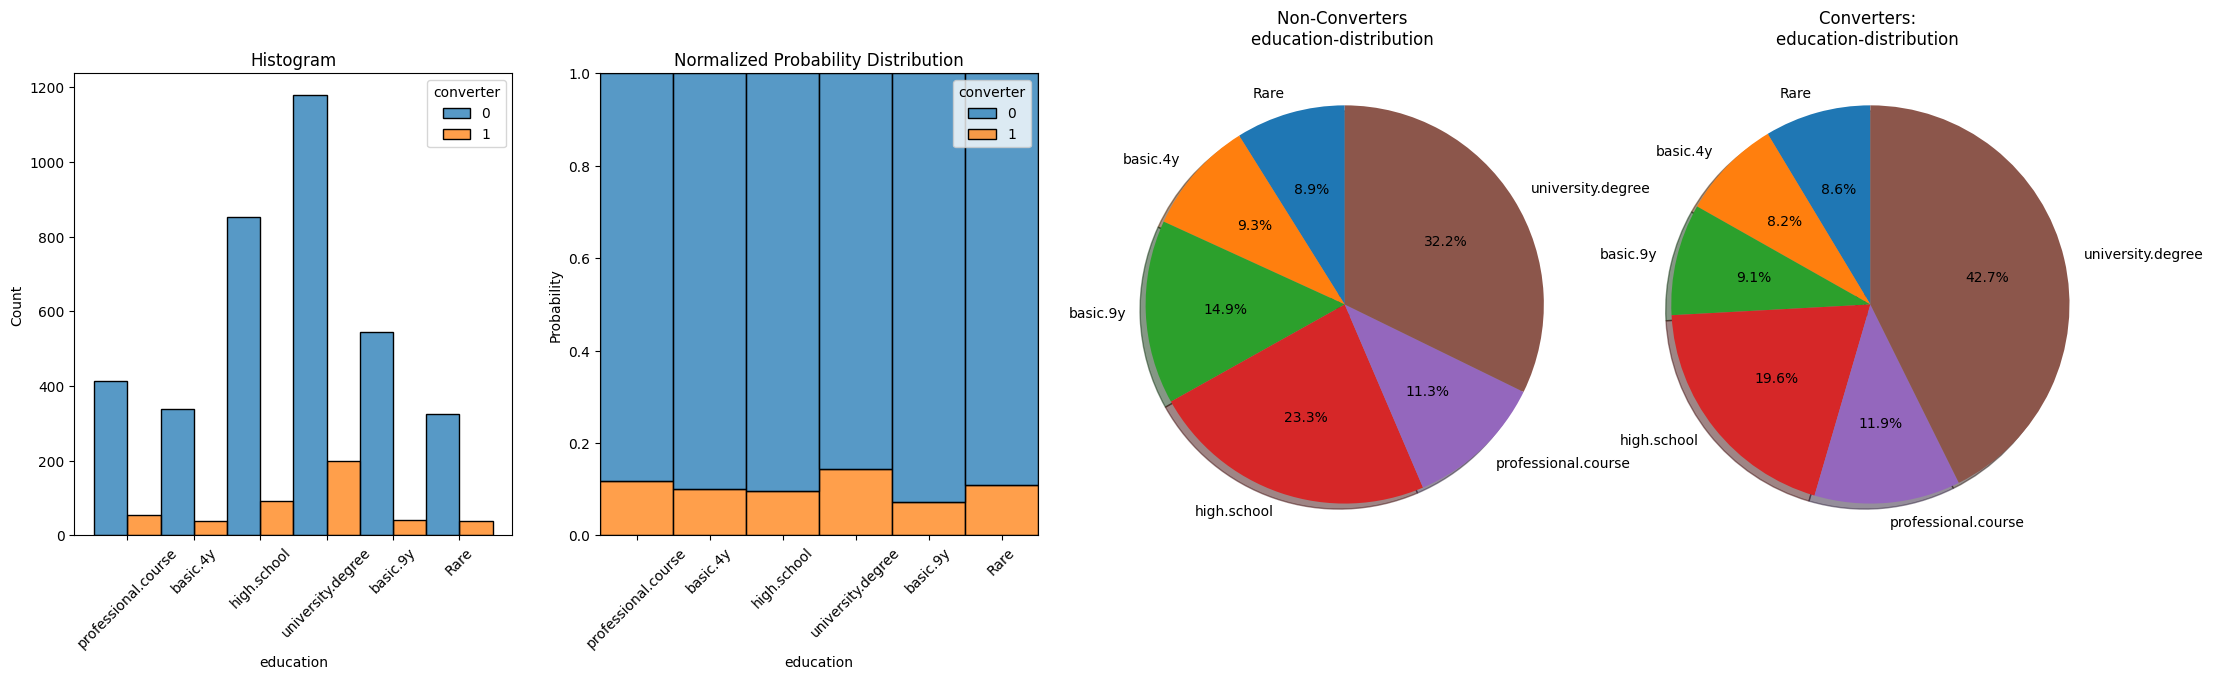

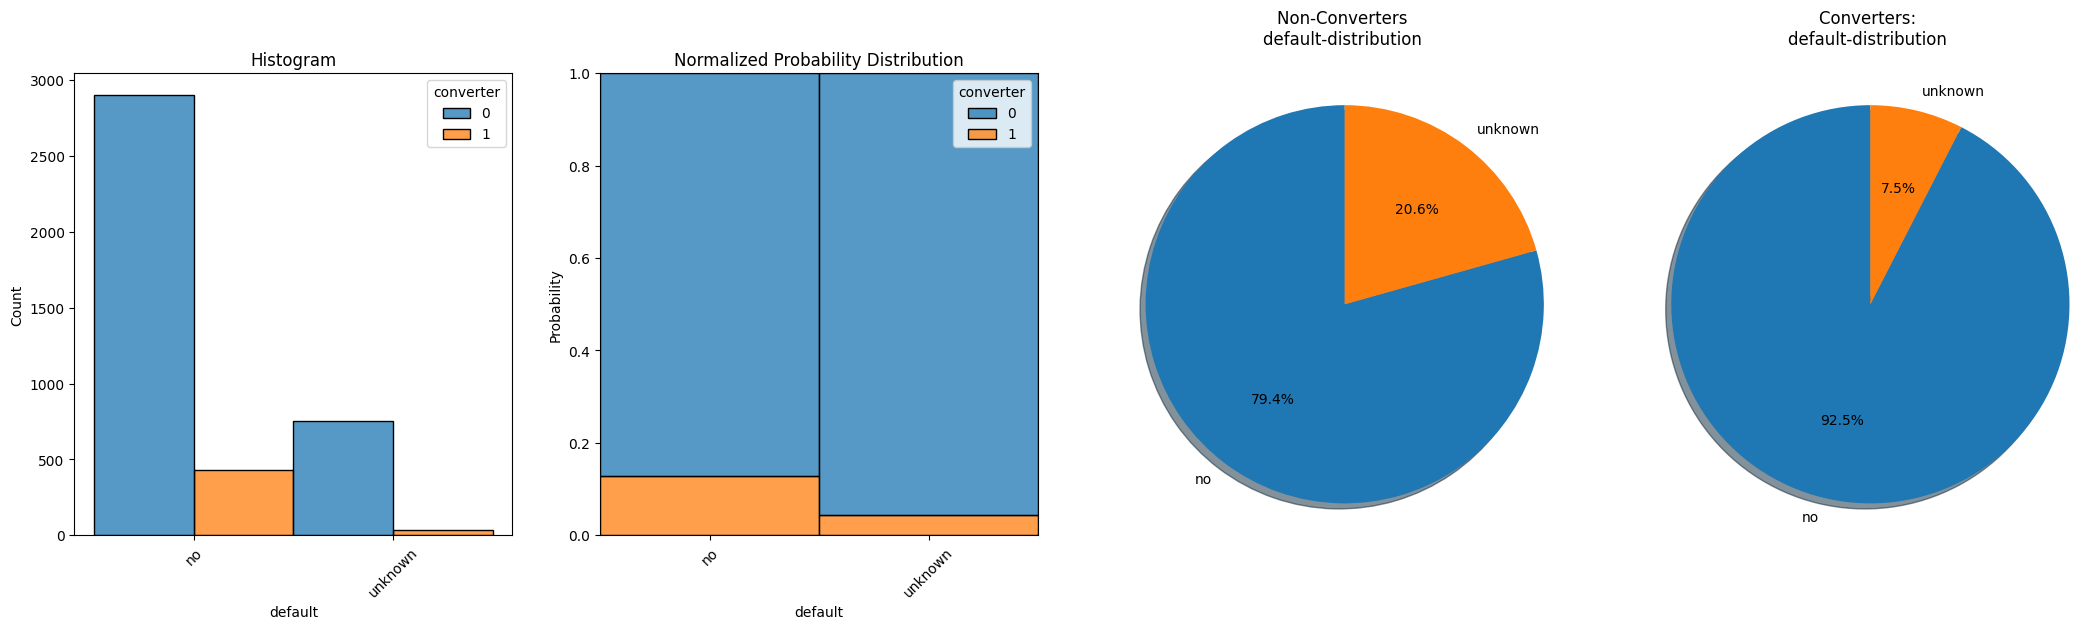

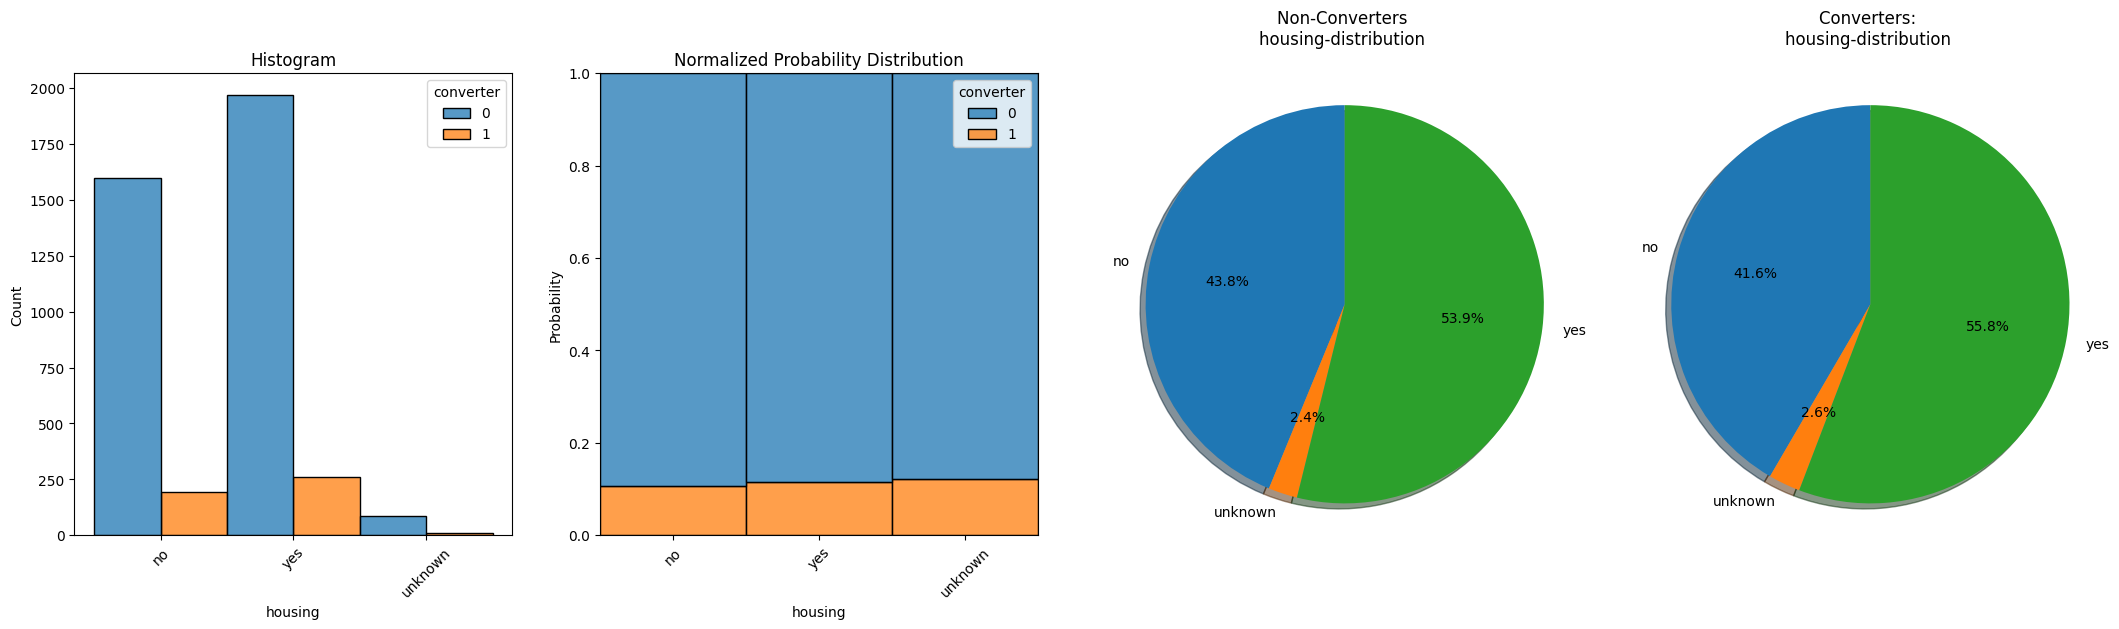

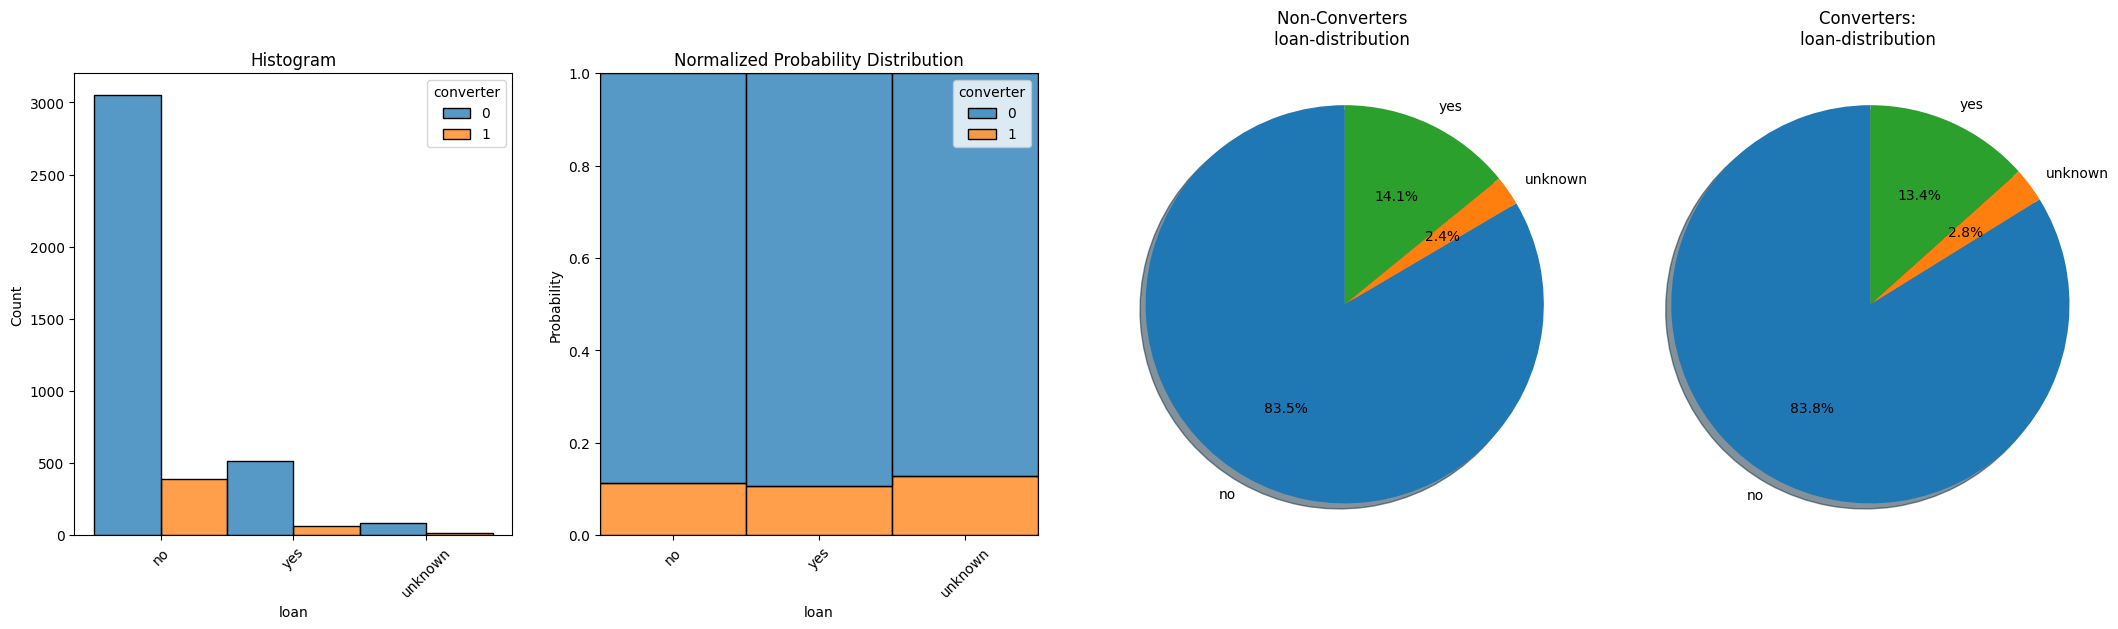

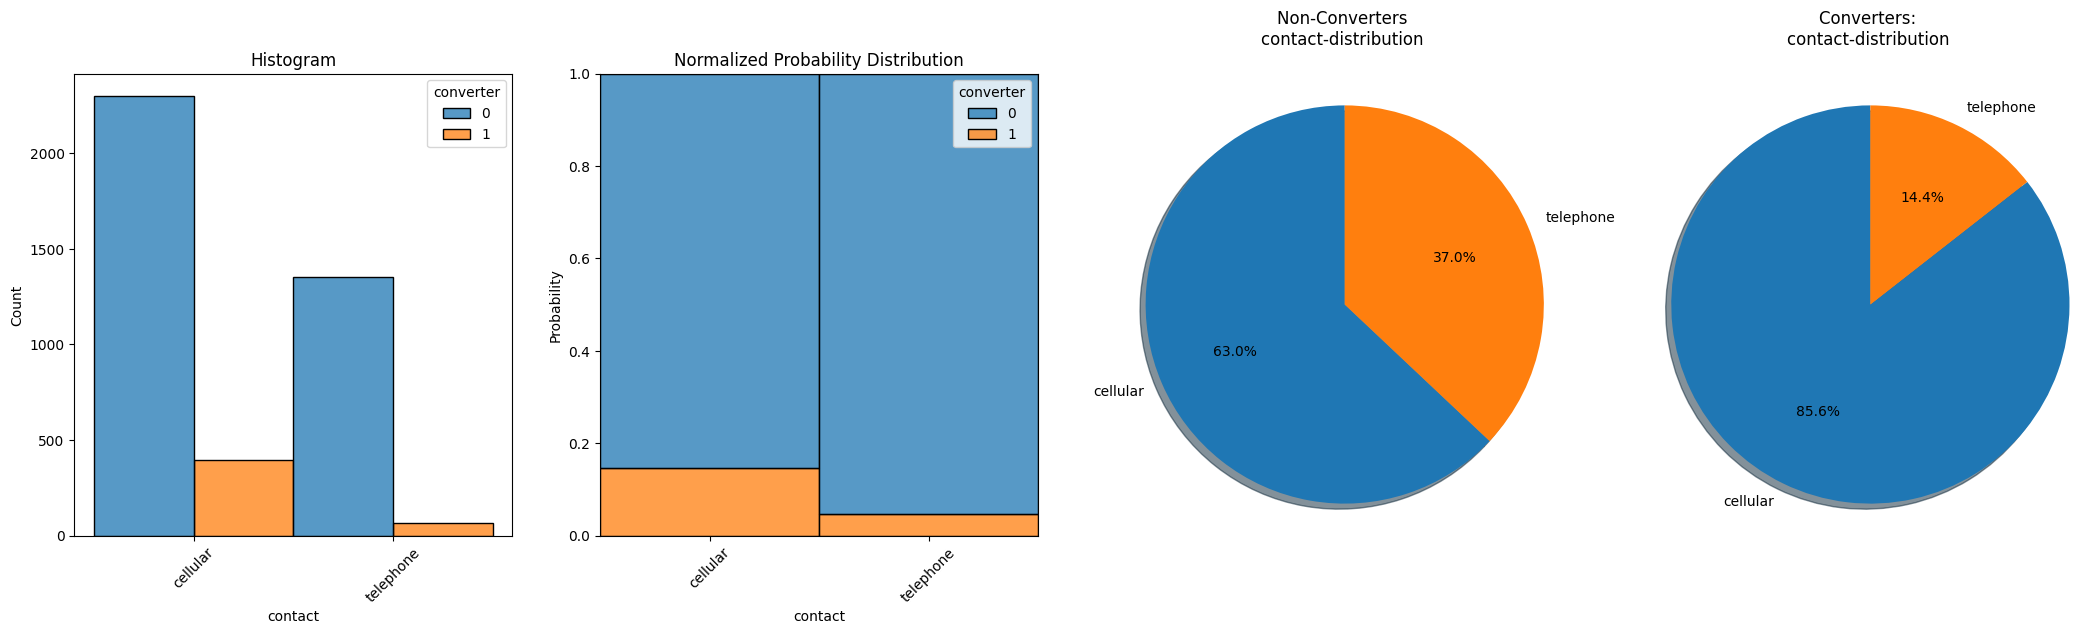

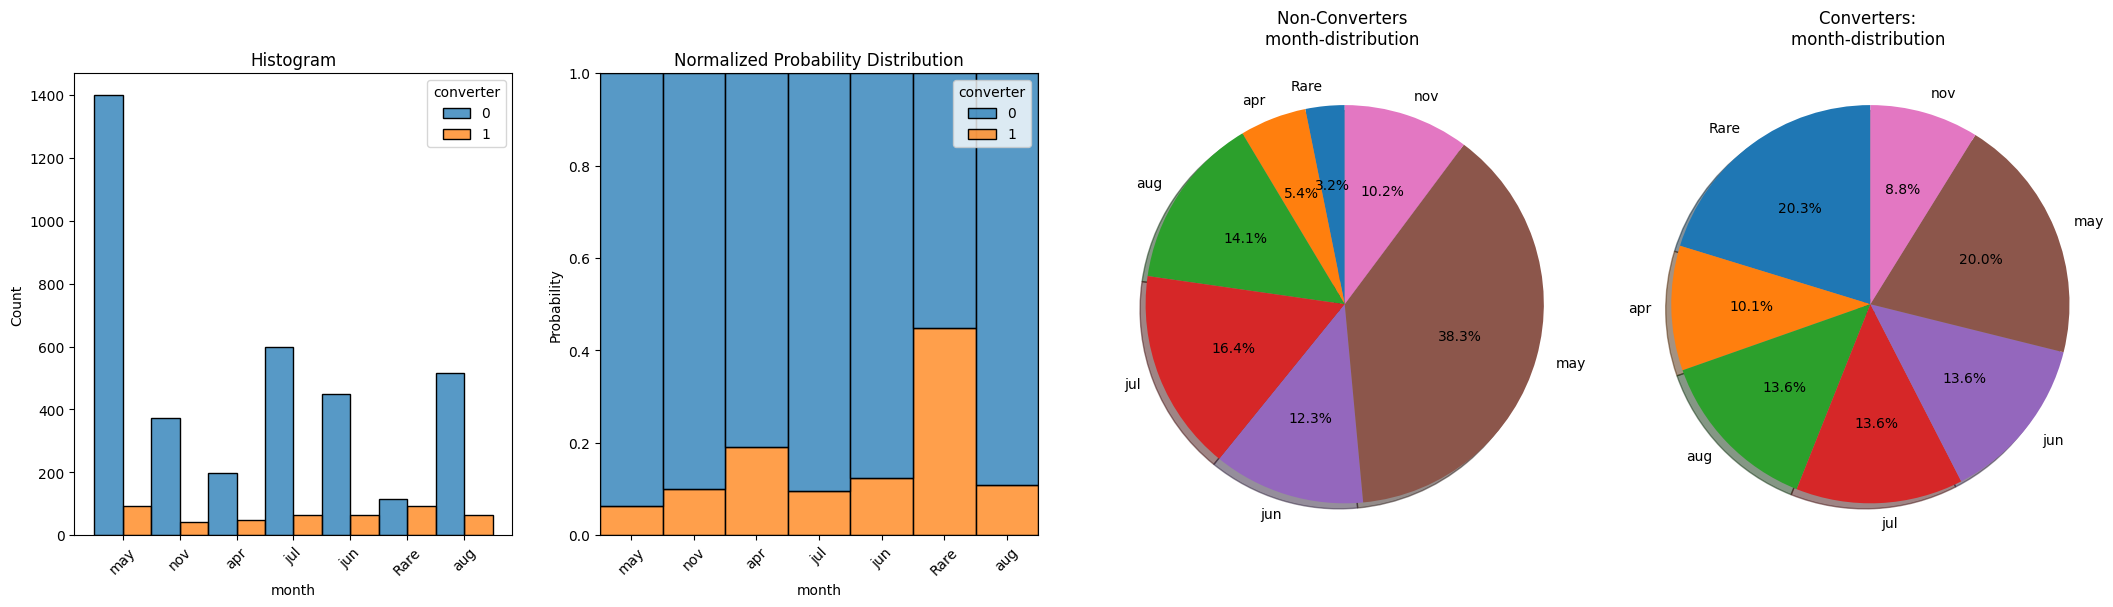

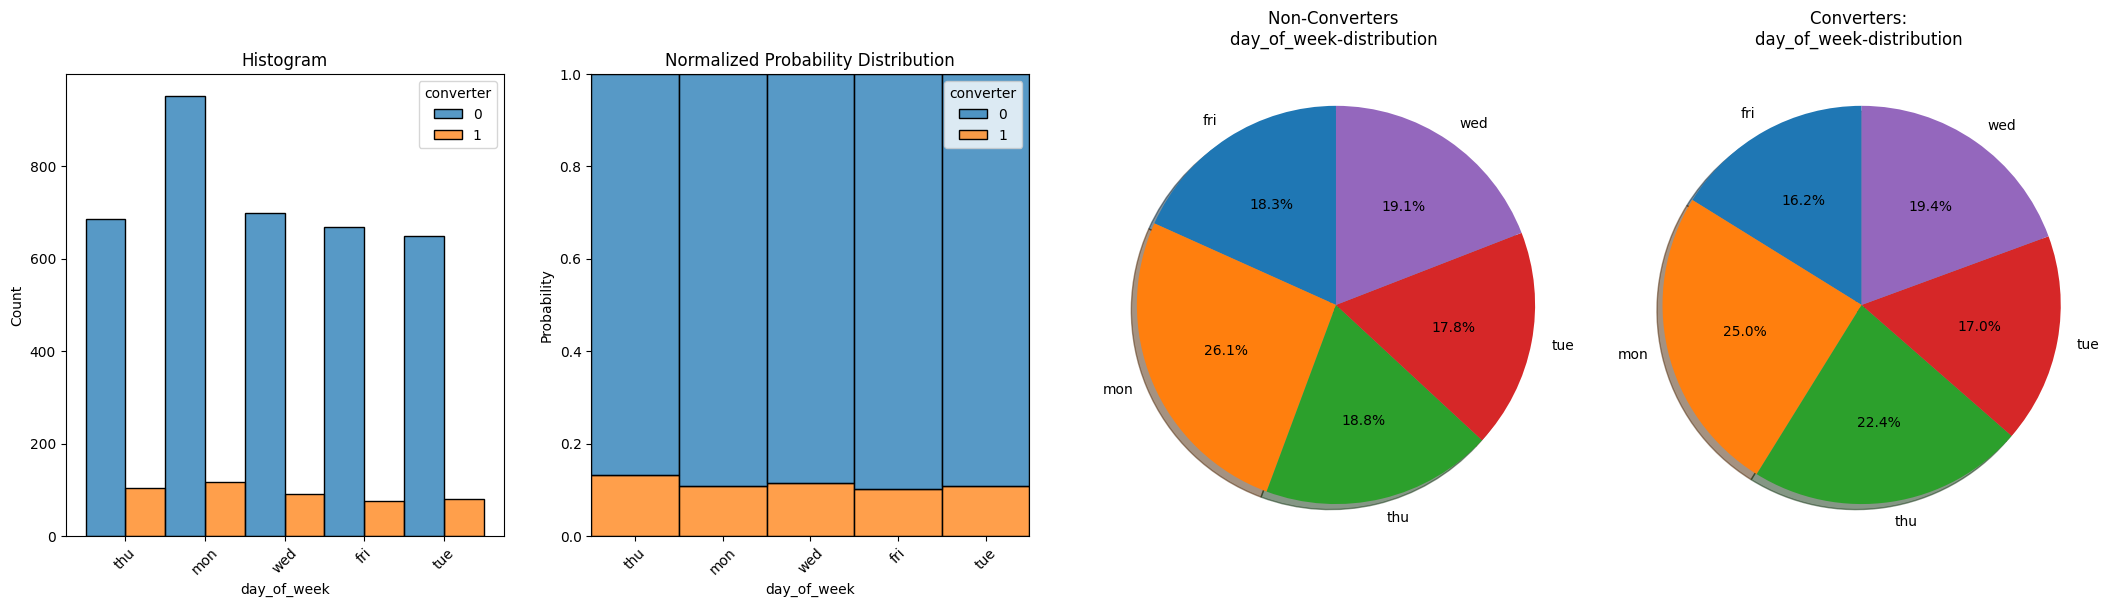

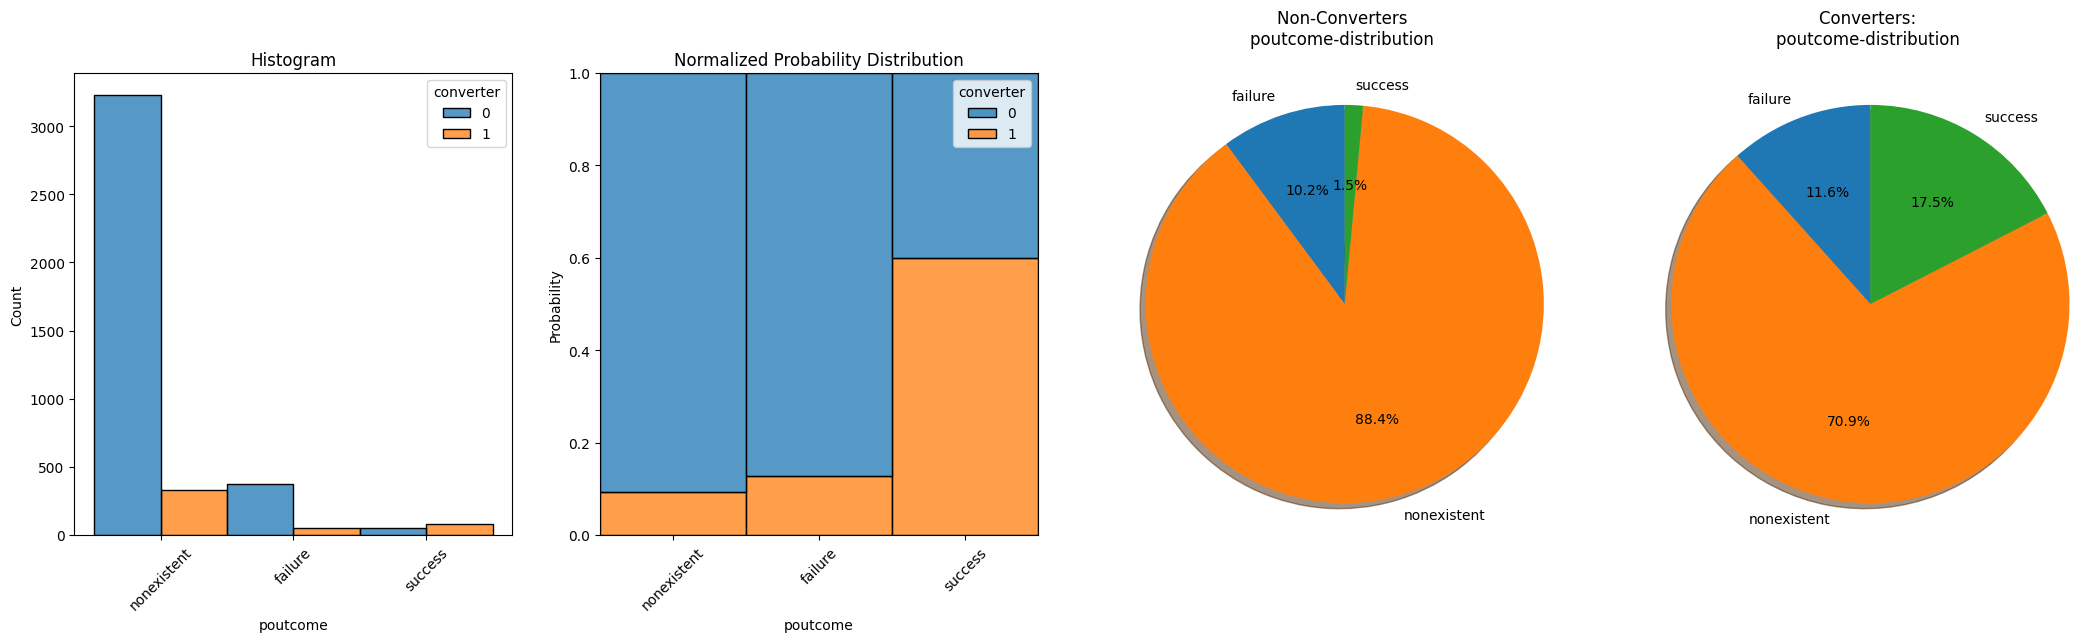

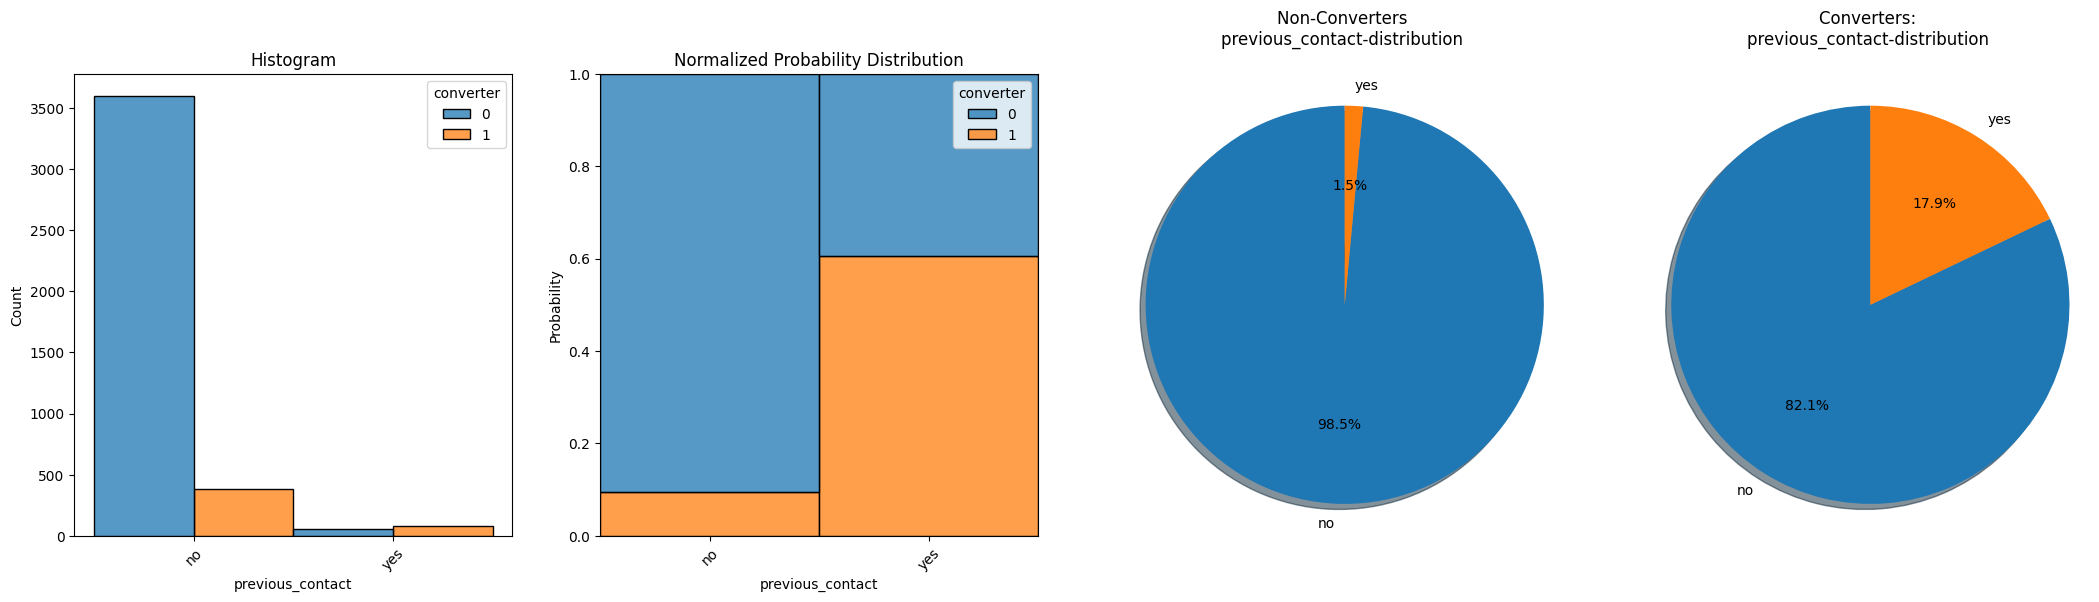

In [46]:
# plot histograms
for feat in categorical_columns:

    fig, ax = plt.subplots(1, 4, figsize=(26,6))

    sns.histplot(
        data = data,
        x = feat,
        hue = 'converter',
        stat='count',
        multiple='dodge',
        ax = ax[0]
    )
    ax[0].set_xticklabels(data[feat].unique(), rotation=45)
    ax[0].set_title('Histogram')

    sns.histplot(
        data = data,
        x = feat,
        hue = 'converter',
        stat='probability',
        multiple='fill',
        ax = ax[1]
    )
    ax[1].set_xticklabels(data[feat].unique(), rotation=45)
    ax[1].set_title('Normalized Probability Distribution')

    # pie-plot for the non-converter
    tmp =  data[data['converter']==0].groupby(by=[feat]).count().iloc[:,0] / data[data['converter']==0].shape[0]
    ax[2].pie(
            x=tmp.values.tolist(), 
            labels=tmp.index.to_list(), 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=90
        )
    ax[2].set_title('Non-Converters \n'+feat+'-distribution \n')
    ax[2].axis('equal')

    # pie-plot for the converter
    tmp =  data[data['converter']==1].groupby(by=[feat]).count().iloc[:,0] / data[data['converter']==1].shape[0]
    ax[3].pie(
            x=tmp.values.tolist(), 
            labels=tmp.index.to_list(), 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=90
        )
    ax[3].set_title('Converters: \n'+feat+'-distribution \n')
    ax[3].axis('equal')

    # save figure
    fig.savefig(
        fname='../images/'+feat+'_dist.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight')

    #plt.show()

## One-Hote Encoding

In [47]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [48]:
# hotencode train data
X_train_hot_enc = enc.fit_transform(X_train[categorical_columns])
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc.head()

,age,campaign,pdays,previous,job_admin.,job_blue-collar,job_management,job_services,job_technician,marital_married,...,month_jun,month_may,month_nov,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,previous_contact_yes
13583,25.0,3.0,16.148069,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5572,42.0,1.0,16.148069,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4906,44.0,2.0,16.148069,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
24720,37.0,1.0,16.148069,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1298,31.0,1.0,16.148069,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [49]:
# hotencode test data
X_test_hot_enc = enc.transform(X_test[categorical_columns])
X_test_cat_hotenc = pd.DataFrame(X_test_hot_enc, columns=enc.get_feature_names_out()) 
X_test_cat_hotenc.index = X_test.index 
X_test_hotenc = pd.concat([X_test[numeric_columns], X_test_cat_hotenc], axis=1) 
X_test_hotenc.head()

Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros


,age,campaign,pdays,previous,job_admin.,job_blue-collar,job_management,job_services,job_technician,marital_married,...,month_jun,month_may,month_nov,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,previous_contact_yes
9909,55.0,1.0,16.148069,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
8714,38.0,4.0,16.148069,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
11249,39.0,2.0,16.148069,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
26948,31.0,3.0,16.148069,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
11755,53.0,3.0,16.148069,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [50]:
# Save one hot encoder
with open('../artifacts/enc.pickle', 'wb') as filename:
    pickle.dump(enc, filename)

# Training Simple Sklearn Decision Tree 

### Resampling Training Data to Account for Class Imbalance

In [51]:
# undersample training data to adress the class imbalance

# Create the under-sampler
sampler = RandomUnderSampler(random_state=123)

# Transform the training dataset
X_undersampled, y_undersampled = sampler.fit_resample(X_train_hotenc, y_train)
y_undersampled.shape

(928,)

In [52]:
dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=3,
    min_samples_leaf=3, 
    random_state=123
)

In [53]:
# fit undersampled data
dt.fit(X_undersampled, y_undersampled)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3,
                       random_state=123)

In [54]:
# evaluate accuracy on training set
dt.score(X_train_hotenc, y_train)

0.4264205925206411

In [55]:
# evaluate accuracy on test set
dt.score(X_test_hotenc, y_test)

0.4236039924467224

### Tuning Decision Tree

In [56]:
# parameters for Decision Tree
parameters = {
    'max_depth': (3, 4, 5, None),
    'min_samples_split': (1, 2, 3, 4, 5, 6),
    'min_samples_leaf': (1, 2, 3, 4, 5, 6)
    }

#### Tune Model on Undersampled Data (Oversampling did non work out well! so no need trying it again!)

In [57]:
model_dt = GridSearchCV(
    dt, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-3)

# fit model on undersampled data
model_dt.fit(X_undersampled, y_undersampled)

# evaluate accuracy on training set
print('recall score in train data: {:.2f}'.format(model_dt.score(X_train_hotenc, y_train))) 

# evaluate accuracy on test set
print('recall score in test data: {:.2f}'.format(model_dt.score(X_test_hotenc, y_test)))

recall score in train data: 0.84
recall score in test data: 0.61



72 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\sklearn\tree\_classes.py", line 969, in fit
    super().fit(
  File "c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\sklearn\tree\_classes.py", line 265, in fit
    check_scalar(
  File "c:\Users\Sebas\anaconda3\envs\customer_cluster_app\lib\site-packages\sklearn\utils\validation.py", line

In [58]:
# show best model parameters
model_dt.best_params_

{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2}

# Training Sklearn Random Forest

In [59]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=3,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [60]:
rf.fit(X_train_hotenc, y_train)

RandomForestClassifier(max_depth=3, max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [61]:
# evaluate accuracy on training set
rf.score(X_train_hotenc, y_train)

0.894851869839728

In [62]:
# evaluate accuracy on test set
rf.score(X_test_hotenc, y_test)

0.8967089290531427

### Tuning Random Forest

In [63]:
# parameters for Random Forest
parameters = {
    'n_estimators': (50, 100, 200, 400),
    'max_depth': (3, 5, None),
    'class_weight' : (None, "balanced")
    }

model_rf = GridSearchCV(
    rf, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-3)

In [64]:
model_rf.fit(X_train_hotenc, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=3, max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-3,
             param_grid={'class_weight': (None, 'balanced'),
                         'max_depth': (3, 5, None),
                         'n_estimators': (50, 100, 200, 400)},
             scoring=make_scorer(recall_score))

In [65]:
# evaluate recall score on training set
model_rf.score(X_train_hotenc, y_train)

0.6594827586206896

In [66]:
# evaluate recall score on test set
model_rf.score(X_test_hotenc, y_test)

0.5778256704980843

In [67]:
model_rf.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, n_estimators=50, random_state=123)

# Training Sklearn Gradient Boosting

In [68]:
# get class imbalance correction factor for minority class i.e. converters
class_correction_factor = get_class_imbalance_correction_factor(df, 'y')
class_correction_factor # multiply the minority class with this factor

7.876724137931034

In [69]:
# init model class
gb = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=3,
    max_features='log2', 
    random_state=123)

# fit model without class weighting
gb.fit(X_train_hotenc, y_train)

# evaluate accuracy on training set
print('accuracy score without class weighting in train data: {:.2f}'.format(gb.score(X_train_hotenc, y_train))) 

# evaluate accuracy on test set
print('accuracy score without class weighting in test data: {:.2f}'.format(gb.score(X_test_hotenc, y_test)))


# fit model with class weighting

# define the sample weights
sample_weights = [class_correction_factor if y==1 else 1 for y in y_train]

# fit the classifier to your training data
gb.fit(X_train_hotenc, y_train, sample_weight=sample_weights)

# evaluate accuracy on training set
print('accuracy score with class weighting in train data: {:.2f}'.format(gb.score(X_train_hotenc, y_train))) 

# evaluate accuracy on test set
print('accuracy score with class weighting in test data: {:.2f}'.format(gb.score(X_test_hotenc, y_test)))


accuracy score without class weighting in train data: 0.90
accuracy score without class weighting in test data: 0.90
accuracy score with class weighting in train data: 0.77
accuracy score with class weighting in test data: 0.75


### Tuning Gradient Boosting

In [70]:
# hyper-parameters for Gradient Boosting
parameters = {
    'n_estimators': (50, 100, 200),
    'max_depth': (3, 5, 7, None)
}


#### Tune Model Without Sample Weighting

In [71]:
# set up the model
model_gb = GridSearchCV(
    gb, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-3)

# fit the model with equal class weights and with class weights adapted to class imbalance
model_gb.fit(X_train_hotenc, y_train)

# evaluate accuracy on training set
print('recall score without class weighting in train data: {:.2f}'.format(model_gb.score(X_train_hotenc, y_train)))

# evaluate accuracy on test set
print('recall score without class weighting in test data: {:.2f}'.format(model_gb.score(X_test_hotenc, y_test)))

# get best parameters
print('model best parameters: ', model_gb.best_params_)

recall score without class weighting in train data: 0.81
recall score without class weighting in test data: 0.20
model best parameters:  {'max_depth': 7, 'n_estimators': 200}


#### Tune Model With Sample Weighting

In [72]:
# set up the model
model_gb = GridSearchCV(
    gb, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-3)

# fit the model with equal class weights and with class weights adapted to class imbalance
model_gb.fit(X_train_hotenc, y_train, sample_weight=sample_weights)

# evaluate accuracy on training set
print('recall score without class weighting in train data: {:.2f}'.format(model_gb.score(X_train_hotenc, y_train)))

# evaluate accuracy on test set
print('recall score without class weighting in test data: {:.2f}'.format(model_gb.score(X_test_hotenc, y_test)))

# get best parameters
print('model best parameters: ', model_gb.best_params_)

recall score without class weighting in train data: 0.69
recall score without class weighting in test data: 0.62
model best parameters:  {'max_depth': 3, 'n_estimators': 50}


# Model Evaluation

## Single Decision Tree Evaluation
### Area Under Curve and Area Under Recall-Precision Curve

AUC Decision Tree:  0.651964210128575
AUPRC Decision Tree:  0.18048175459099502


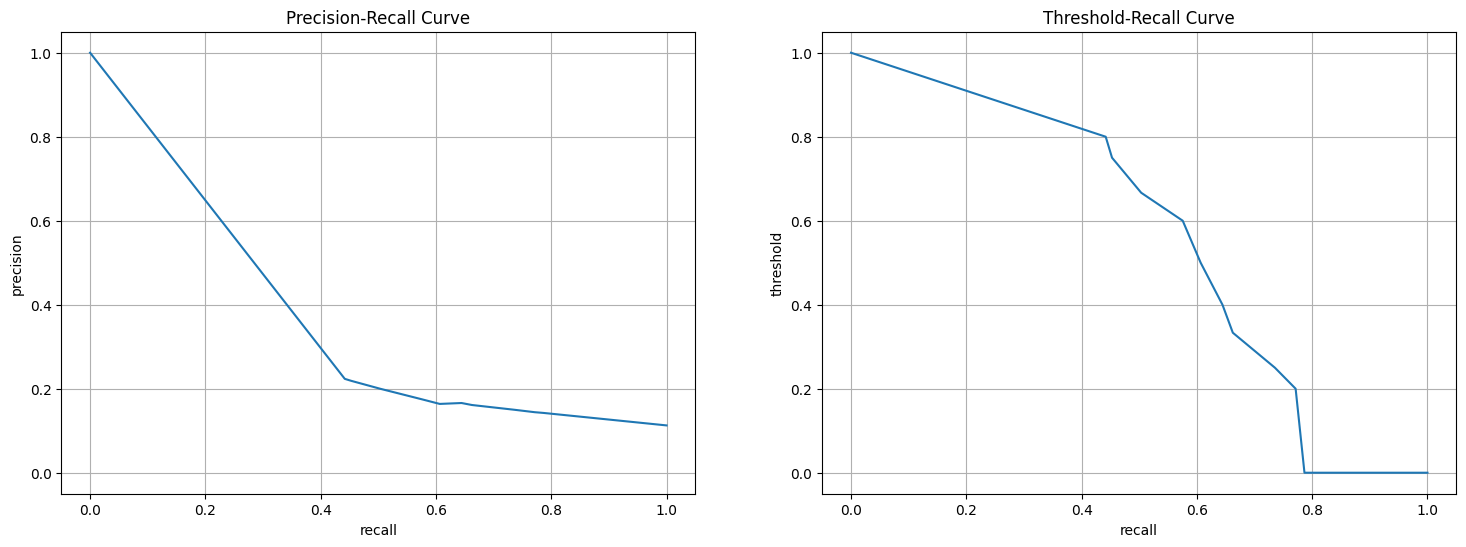

In [73]:
# calculate AUC for decision tree
auc = roc_auc_score(y_test, model_dt.predict_proba(X_test_hotenc)[:,1])
print('AUC Decision Tree: ', auc)

# calculate AUPRC for decision tree
auprc = average_precision_score(y_test, model_dt.predict_proba(X_test_hotenc)[:,1])
print('AUPRC Decision Tree: ', auprc)

# plot recall vs precision for decision tree model
fig = plot_threshold_recall_precision_curves(model_dt, X_test_hotenc, y_test)

# save figure
fig.savefig(
        fname='../images/recall_precision_tree.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
)

### Confusion Matrices

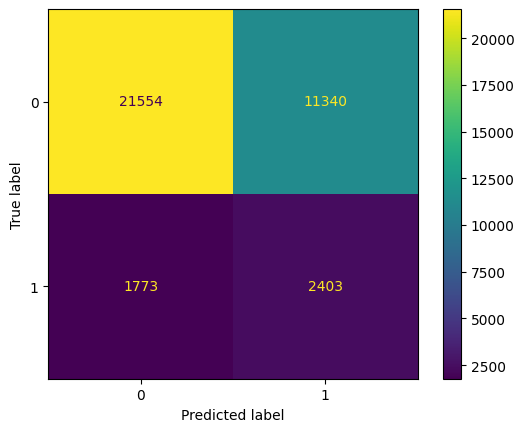

In [74]:
# lets say for whatever reason we want the recall to be around 40%, hence we accept a precision of around 40%; therefore we need to choose a threshold of around 60%
# let´s relabel using that threshold of 60%

# plot confusion matrix for test data
disp = plot_confusion_matrix(
    features=X_test_hotenc, 
    labels=y_test, 
    sklearn_model=model_dt,
    threshold=0.6)

# save figure
disp.figure_.savefig(
    fname='../images/confusion_matrix_tree.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

### Visualize Tuned Decision Tree

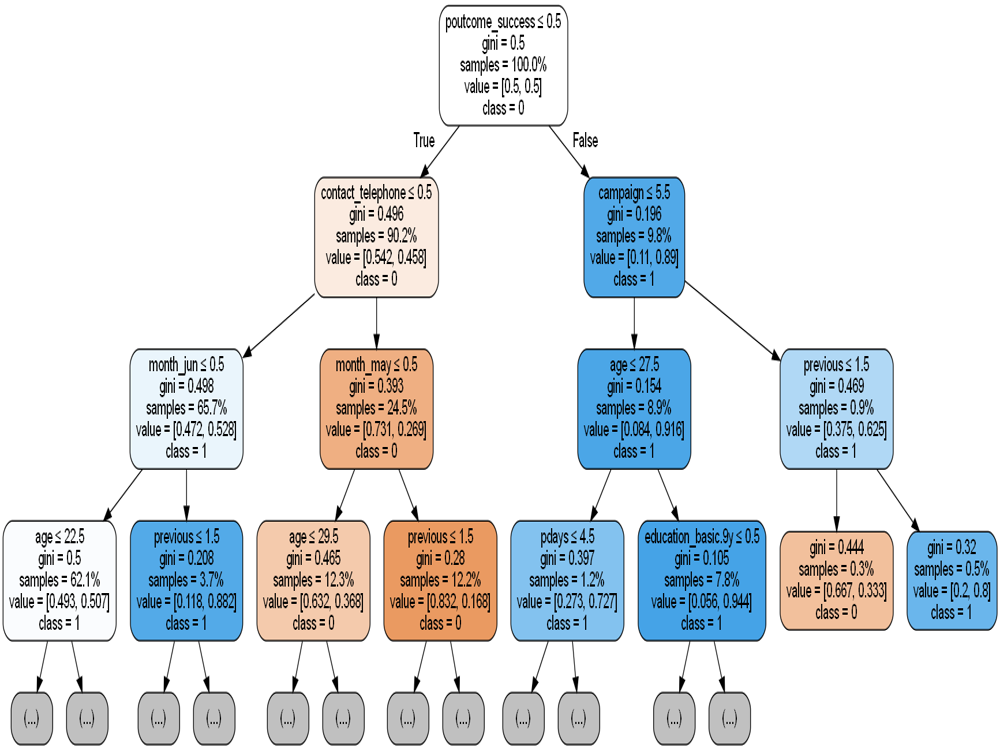

In [75]:
dot_data = tree.export_graphviz(
    decision_tree=model_dt.best_estimator_,
    max_depth=3,
    feature_names=X_test_hotenc.columns.tolist(),
    class_names=['0', '1'],
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True
)

graph = graphviz.Source(dot_data)

# save image locally
graph.render(
    filename='../images/decision_tree_analysis',
    format='png',
    cleanup =True
)

# resize image
img = Image.open('../images/decision_tree_analysis.png')
img_resized = img.resize((1000, 750))
img_resized.save('../images/decision_tree_analysis.png')

# show graph
img_resized

## Random Forest Evaluation
### Area Under Curve and Area Under Recall-Precision Curve

AUC Random Forest:  0.7361111293107525
AUPRC Random Forest:  0.3695626906386782


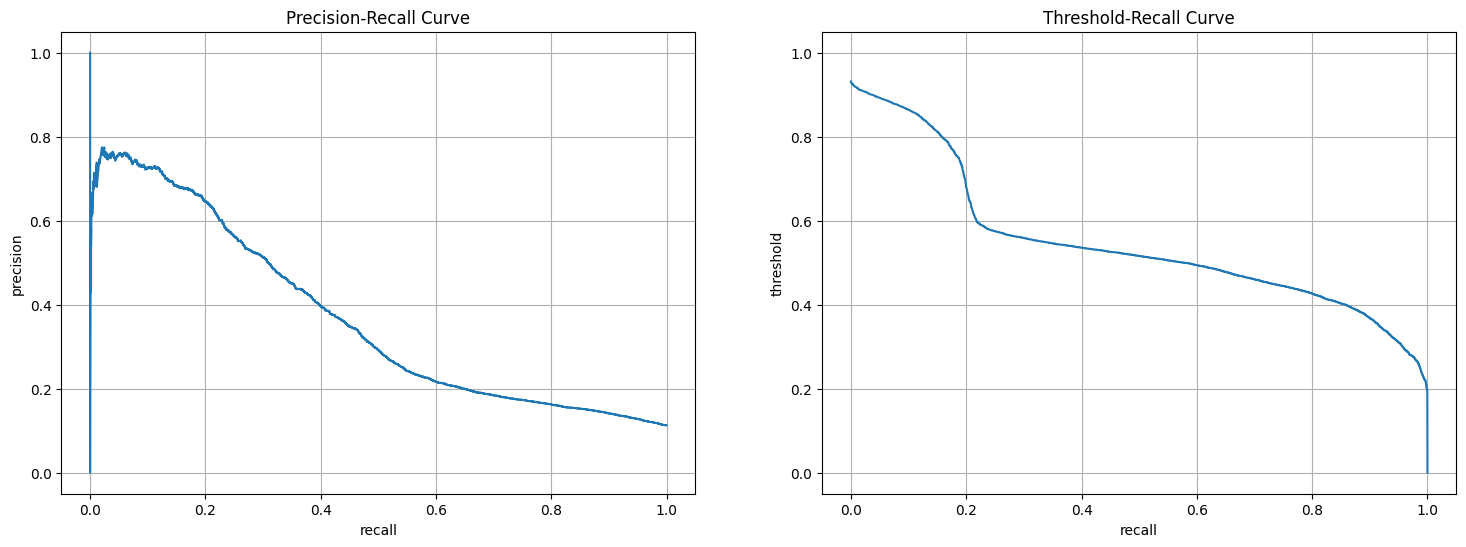

In [76]:
# calculate AUC for random forest
auc = roc_auc_score(y_test, model_rf.predict_proba(X_test_hotenc)[:,1])
print('AUC Random Forest: ', auc)

# calculate AUPRC for random forest
auprc = average_precision_score(y_test, model_rf.predict_proba(X_test_hotenc)[:,1])
print('AUPRC Random Forest: ', auprc)

# plot recall vs precision for random forest model
fig = plot_threshold_recall_precision_curves(model_rf, X_test_hotenc, y_test)

# save figure
fig.savefig(
        fname='../images/recall_precision_rf.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
)

### Confusion Matrices

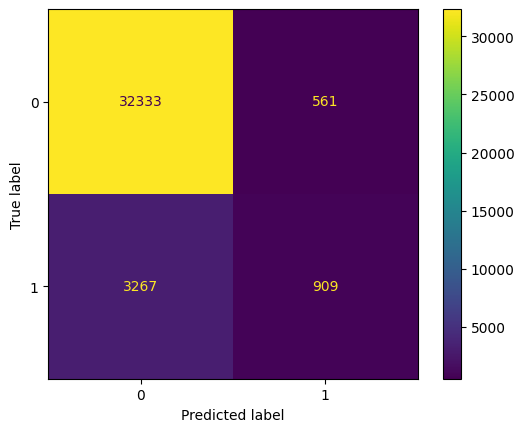

In [77]:
# lets say for whatever reason we want the recall to be around 40%, hence we accept a precision of around 40%; therefore we need to choose a threshold of around 60%
# let´s relabel using that threshold of 60%

# plot confusion matrix for test data
disp = plot_confusion_matrix(
    features=X_test_hotenc, 
    labels=y_test, 
    sklearn_model=model_rf,
    threshold=0.6)

# save figure
disp.figure_.savefig(
    fname='../images/confusion_matrix_rf.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

## Gradient Boosted Trees Evaluation
### Area Under Curve and Area Under Recall-Precision Curve

AUC Gradient Boosting Classifier:  0.7396425658861961
AUPRC Gradient Boosting Classifier:  0.3693311950427245


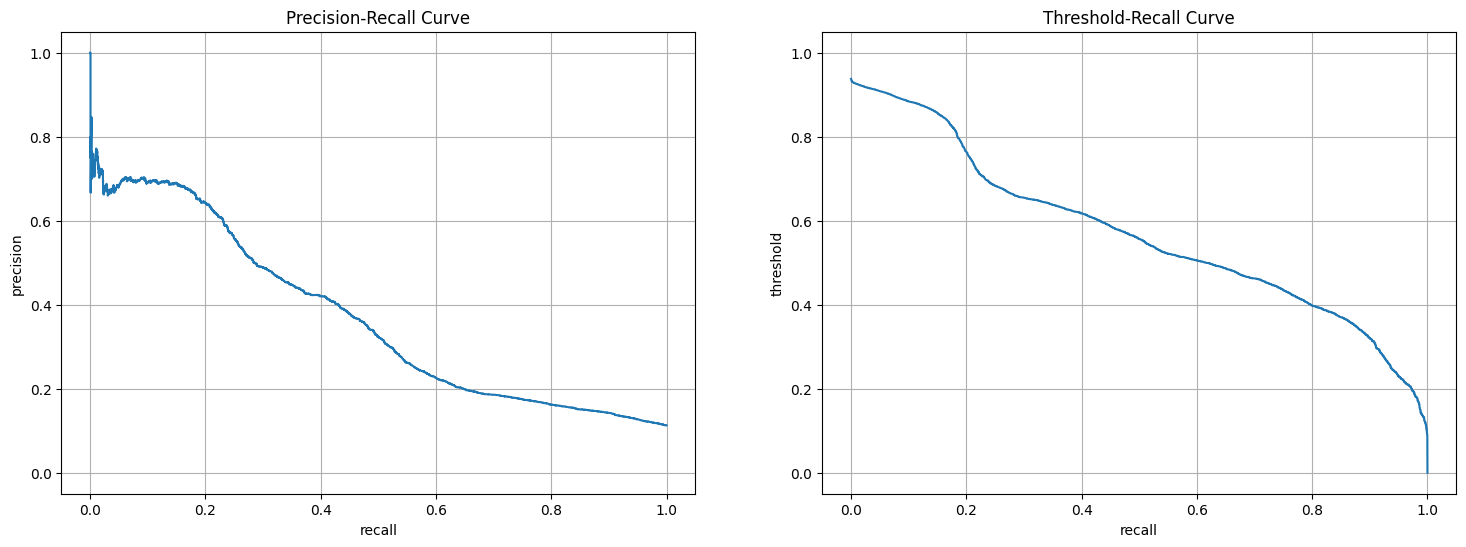

In [78]:
# calculate AUC for gradient boosting classifier
auc = roc_auc_score(y_test, model_gb.predict_proba(X_test_hotenc)[:,1])
print('AUC Gradient Boosting Classifier: ', auc)

# calculate AUPRC for random forest
auprc = average_precision_score(y_test, model_gb.predict_proba(X_test_hotenc)[:,1])
print('AUPRC Gradient Boosting Classifier: ', auprc)

# plot recall vs precision for gradient boosting model
fig = plot_threshold_recall_precision_curves(model_gb, X_test_hotenc, y_test)

# save figure
fig.savefig(
        fname='../images/recall_precision_gb.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
)

### Confusion Matrices

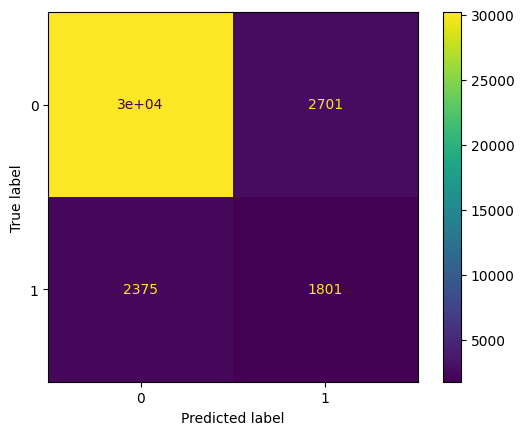

In [79]:
# lets say for whatever reason we want the recall to be around 40%, hence we accept a precision of around 40%; therefore we need to choose a threshold of around 60%
# let´s relabel using that threshold of 60%

# plot confusion matrix for test data
disp = plot_confusion_matrix(
    features=X_test_hotenc, 
    labels=y_test, 
    sklearn_model=model_gb,
    threshold=0.6)

# save figure
disp.figure_.savefig(
    fname='../images/confusion_matrix_gb.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

## Save Best Model

In [80]:
# Save the BEST classifier!!!
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model_gb, filename)

# Model Explainability Using Shap Values

In [81]:
X_test_hotenc.shape

(37070, 36)

In [82]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model_gb.best_estimator_,
    feature_perturbation = 'interventional',
    output = 'probability')

# get random sample
X = X_test_hotenc.sample(1000)

# calculate shap values
shap_values = explainer.shap_values(X)

In [83]:
def plot_shap_values(shap_values, topn=5, plot_type='violin'):
    """Violin plot of the shap values"""
    shap.summary_plot(
        shap_values = shap_values, 
        features = X,
        sort=True,
        plot_size=(10.0,8.0),
        show=False,
        max_display=topn,
        plot_type=plot_type
        )
    ax=plt.gca()
    ax.set_title('Shap Values')
    ax.grid()
    #ax.set_xlim(-.5,.5)
    fig = plt.gcf()
    return fig

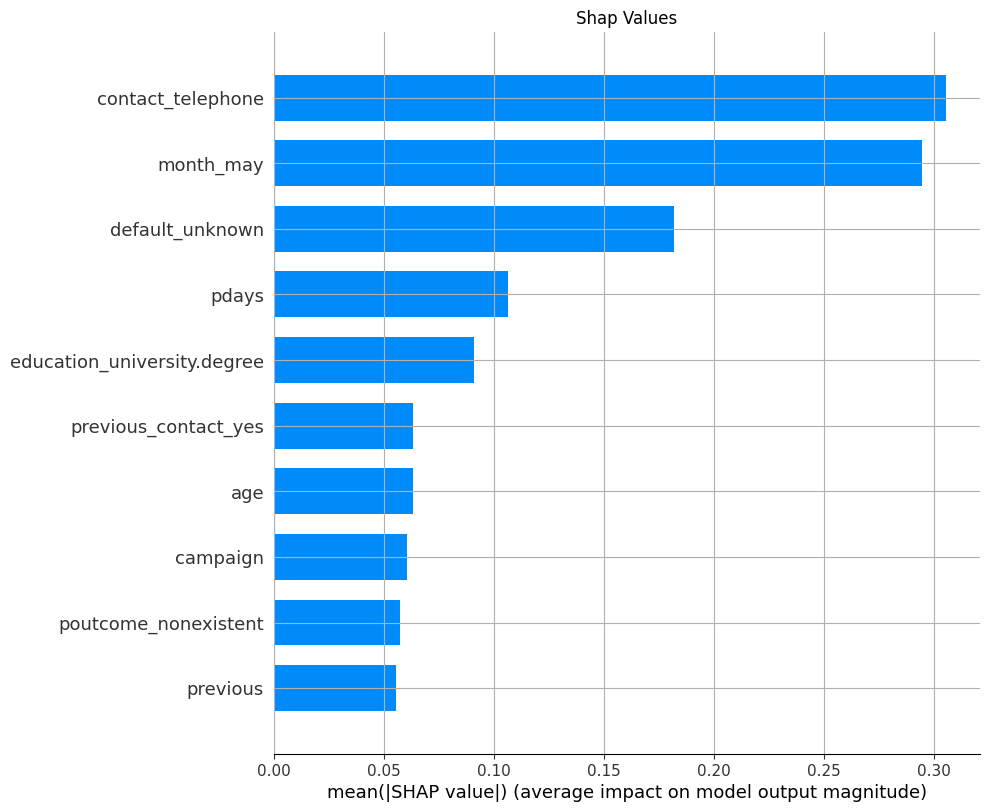

In [84]:
fig = plot_shap_values(shap_values, topn=10, plot_type='bar')

# save figure
fig.savefig(
    fname='../images/shap_values_bar.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


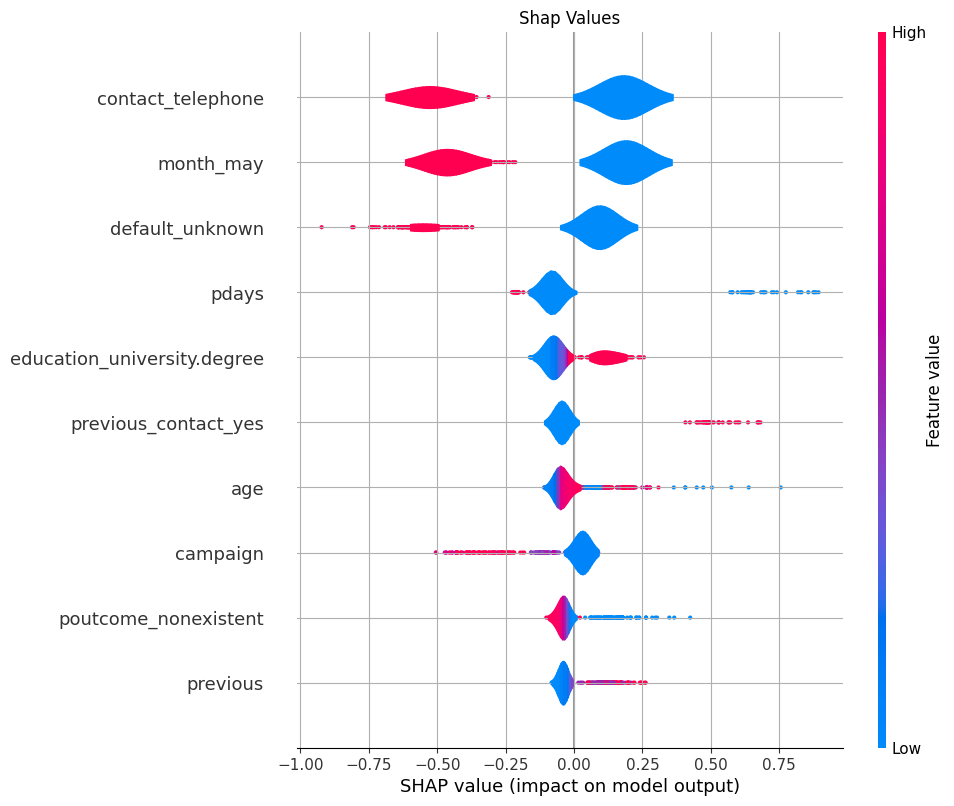

In [85]:
fig = plot_shap_values(shap_values, topn=10, plot_type='violin')

# save figure
fig.savefig(
    fname='../images/shap_values_violin.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

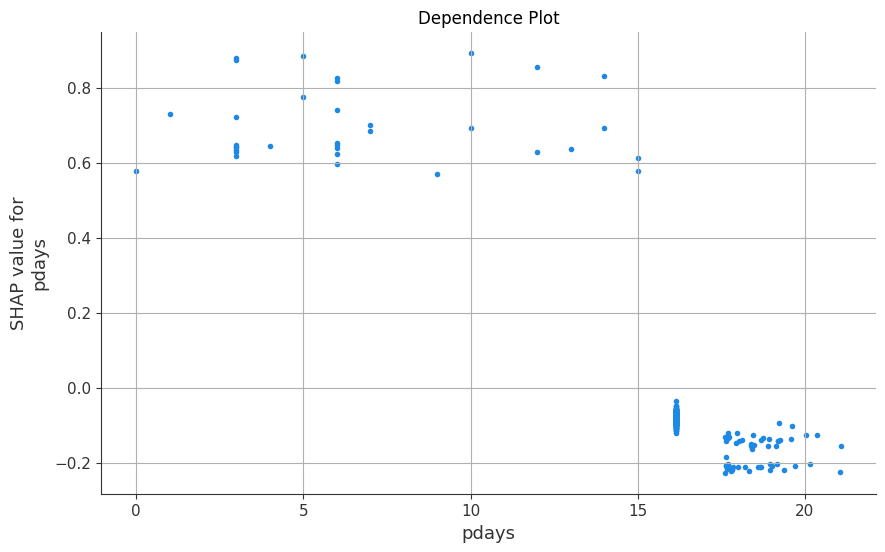

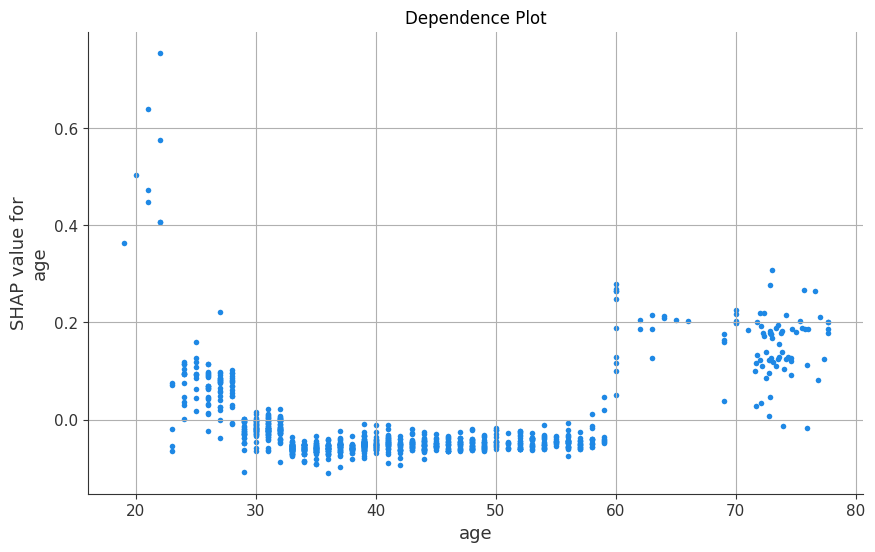

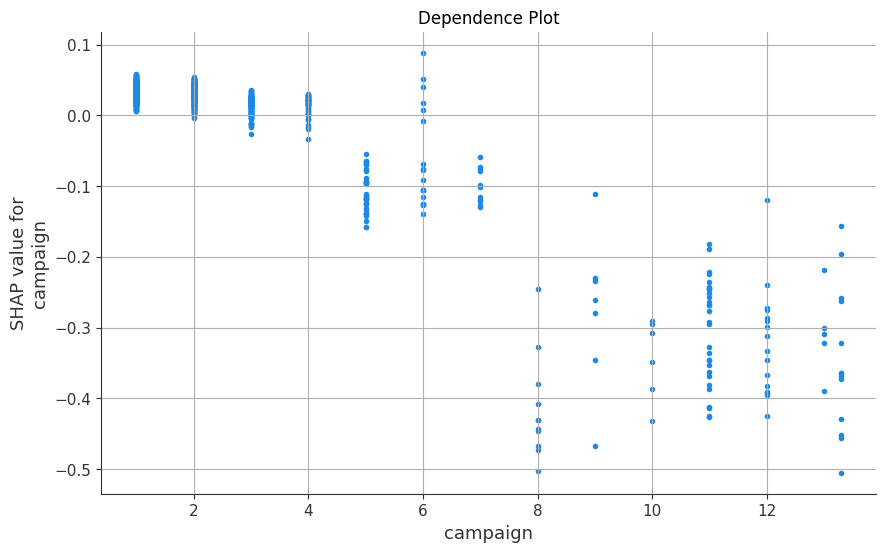

In [86]:
# plot dependence plots for the numerical features
for feat in ['pdays', 'age', 'campaign']:
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.grid()
    ax.set_title('Dependence Plot')
    #ax.set_ylim(-1,1)
    shap.dependence_plot(
        ind = feat,
        shap_values = shap_values, 
        features = X,
        interaction_index=None,
        ax=ax
    )

    # save figure
    fig.savefig(
        fname='../images/shap_dependence_plot_'+feat+'.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
    )
    